# Building Networks
## The AMP Salvage Network
The previous chapter described the integration of two pathways. We will now add yet another set of reactions to the previously integrated pathways. The AMP input and output that was described earlier by two simple reactions across the system boundary represent a network of reactions that are called purine degradation and salvage pathways. The salvage pathways recycle a pentose through the attachment of an imported purine base to effectively reverse AMP degradation. AMP degradation and salvage are low flux pathways but have several genetic mutations in the human population that cause serious diseases. Thus, even though fluxes through these pathways are low, their function is critical. As we have seen, many of the long-term dynamic responses are determined by the adjustment of the total adenylate cofactor pool. In this chapter, we integrate the degradation and salvage pathways to form a core metabolic network for the human red blood cell.

**MASSpy** will be used to demonstrate some of the topics in this chapter.

In [1]:
from mass import (
    MassModel, MassMetabolite, MassReaction,
    Simulation, MassSolution, strip_time)
from mass.example_data import create_example_model
from mass.util.matrix import nullspace, left_nullspace, matrix_rank
from mass.visualization import (
    plot_time_profile, plot_phase_portrait, plot_tiled_phase_portraits,
    plot_comparison)

Other useful packages are also imported at this time.

In [2]:
from os import path
from cobra import DictList
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym

Some options and variables used throughout the notebook are also declared here.

In [3]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.3f}'.format
S_FONT = {"size": "small"}
L_FONT = {"size": "large"}
INF = float("inf")

## AMP Metabolism  
AMP metabolism forms a sub-network in the overall red blood cell metabolic network. We will first consider its properties before we integrate it with the combined glycolytic and pentose pathway model. 

### The AMP metabolic sub-network  
AMP is simultaneously degraded and synthesized, creating a dynamic balance (Figure 12.1). The metabolites that are found in these pathways and that are over and above those that are in the integrated glycolytic and pentose pathway network are listed in Table 12.1. To build this sub-network, prior to integration with the glycolytic and pentose pathway network, we need consider a sub-network comprised of the metabolites shown in Table 12.1. The reactions that take place in the degradation and biosynthesis of AMP are shown in Table 12.2. 

![Figure-12-1](../images/Ch12/Figure-12-1.png)

**Figure 12.1:** The nucleotide metabolism considered in this chapter. There are two biochemical ways in which AMP is degraded and two ways in which it is synthesized.

In [4]:
ampsn = create_example_model("SB2_AMPSalvageNetwork")

### Degradation  
AMP can be degraded either by dephosphorylation or by deamination. In the former case, adenosine (ADO) is formed and can cross the cell membrane to enter plasma. In the latter case, IMP is formed and can then subsequently be dephosphorylated to form inosine (INO). INO can then cross the cell membrane, or be further degraded to form a pentose (R1P) and the purine base hypoxanthine (HYP), the latter of which can be exchanged with plasma. HYP will become uric acid, the accumulation of which causes hyperuricemia (gout). 

### Biosynthesis  
The red blood cell does not have the capacity for de novo adenine synthesis. It can synthesize AMP in two different ways. First, it can phosphorylate ADO directly to form AMP using an ATP to ADP conversion. This ATP use creates an energy load met by glycolysis. A second process to offset degradation of adenine is the salvage pathway, in which adenine (ADE) is picked up from plasma and is combined with phosphoribosyl diphosphate (PRPP) to form AMP. PRPP is formed from R5P using two ATP equivalents, where the R5P is formed from isomerization of R1P that is formed during INO degradation. In this way, the pentose is recycled to re-synthesize AMP at the cost of two ATP molecules. The R5P can also come from the pentose phosphate pathway in an integrated network. 

### The biochemical reactions

**Table 12.1:** Intermediates of AMP degradation and synthesis, their abbreviations and steady state concentrations. The concentrations given are those typical for the human red blood cell. The index on the compounds is added to that for the combined glycolysis and pentose phosphate pathway, (Table 11.1).

In [5]:
metabolite_ids = [m.id for m in ampsn.metabolites
                  if m.id not in ["r5p_c", "atp_c", "adp_c", 
                                  "amp_c", "pi_c", "h_c", "h2o_c"]]

table_12_1 = pd.DataFrame(
    np.array([metabolite_ids,
              [met.name for met in ampsn.metabolites 
               if met.id in metabolite_ids],
              [ampsn.initial_conditions[met] for met in ampsn.metabolites 
               if met.id in metabolite_ids]]).T,
    index=[i for i in range(33, len(metabolite_ids) + 33)],
    columns=["Abbreviations", "Species", "Initial Concentration"])
table_12_1

Abbreviations                                 Species Initial Concentration
33         adn_c                               Adenosine                0.0012
34         ade_c                                 Adenine                 0.001
35         imp_c                   Inosine monophosphate                  0.01
36         ins_c                                 Inosine                 0.001
37        hxan_c                            Hypoxanthine                 0.002
38         r1p_c              Alpha-D-Ribose 1-phosphate                  0.06
39        prpp_c  5-Phospho-alpha-D-ribose 1-diphosphate                 0.005
40         nh3_c                                 Ammonia              0.091002

**Table 12.2:** AMP degradation and biosynthetic pathway enzymes and transporters, their abbreviations and chemical reactions.The index on the reactions is added to that for the combined glycolysis and pentose pathways (Table 11.2)*

In [6]:
reaction_ids = [r.id for r in ampsn.reactions 
                if r.id not in ["SK_g6p_c", "DM_f6p_c", "SK_amp_c", 
                                "SK_h_c", "SK_h2o_c"]]
table_12_2 = pd.DataFrame(
    np.array([reaction_ids,
              [r.name for r in ampsn.reactions
               if r.id in reaction_ids],
              [r.reaction for r in ampsn.reactions
               if r.id in reaction_ids]]).T,
    index=[i for i in range(34, len(reaction_ids) + 34)],
    columns=["Abbreviations", "Enzymes/Transporter/Load", "Elementally Balanced Reaction"])
table_12_2

Abbreviations                   Enzymes/Transporter/Load  \
34         ADNK1                           Adenosine kinase   
35          NTD7                      5'-nucleotidase (AMP)   
36         AMPDA          Adenosine monophosphate deaminase   
37         NTD11                      5'-nucleotidase (IMP)   
38           ADA                        Adenosine deaminase   
39         PUNP5  Purine-nucleoside phosphorylase (Inosine)   
40           PPM                         Phosphopentomutase   
41         PRPPS     Phosphoribosylpyrophosphate synthetase   
42          ADPT                                              
43          ATPM                ATP maintenance requirement   
44      SK_adn_c                             Adenosine sink   
45      SK_ade_c                               Adenine sink   
46      SK_ins_c                               Inosine sink   
47     SK_hxan_c                          Hypoxanthine sink   
48      SK_nh3_c                               Ammonia sink   
49       SK_pi_c                             Phosphate sink   

                      Elementally Balanced Reaction  
34            adn_c + atp_c --> adp_c + amp_c + h_c  
35                   amp_c + h2o_c --> adn_c + pi_c  
36                  amp_c + h2o_c --> imp_c + nh3_c  
37                   h2o_c + imp_c --> ins_c + pi_c  
38                  adn_c + h2o_c --> ins_c + nh3_c  
39                  ins_c + pi_c <=> hxan_c + r1p_c  
40                                  r1p_c <=> r5p_c  
41       2 atp_c + r5p_c --> 2 adp_c + h_c + prpp_c  
42  ade_c + h2o_c + prpp_c --> amp_c + h_c + 2 pi_c  
43             adp_c + h_c + pi_c --> atp_c + h2o_c  
44                                       adn_c <=>   
45                                       ade_c <=>   
46                                       ins_c <=>   
47                                      hxan_c <=>   
48                                       nh3_c <=>   
49                                        pi_c <=>

**Table 12.3:** The elemental composition and charges of the AMP Salvage Network intermediates. This table represents the matrix $\textbf{E}.$

In [7]:
table_12_3 = ampsn.get_elemental_matrix(array_type="DataFrame", 
                                        dtype=np.int64)
table_12_3

adn_c  ade_c  imp_c  ins_c  hxan_c  r1p_c  r5p_c  prpp_c  atp_c  adp_c  \
C     10      5     10     10       5      5      5       5     10     10   
H     13      5     11     12       4      9      9       8     12     12   
O      4      0      8      5       1      8      8      14     13     10   
P      0      0      1      0       0      1      1       3      3      2   
N      5      5      4      4       4      0      0       0      5      5   
S      0      0      0      0       0      0      0       0      0      0   
q      0      0     -2      0       0     -2     -2      -5     -4     -3   

   amp_c  pi_c  nh3_c  h_c  h2o_c  
C     10     0      0    0      0  
H     12     1      3    1      2  
O      7     4      0    0      1  
P      1     1      0    0      0  
N      5     0      1    0      0  
S      0     0      0    0      0  
q     -2    -2      0    1      0

**Table 12.4:** The elemental and charge balance test on the reactions. All internal reactions are balanced.  Exchange reactions are not.

In [8]:
table_12_4 = ampsn.get_elemental_charge_balancing(array_type="DataFrame", 
                                                  dtype=np.int64)
table_12_4

ADNK1  NTD7  AMPDA  NTD11  ADA  PUNP5  PPM  PRPPS  ADPT  ATPM  SK_adn_c  \
C      0     0      0      0    0      0    0      0     0     0       -10   
H      0     0      0      0    0      0    0      0     0     0       -13   
O      0     0      0      0    0      0    0      0     0     0        -4   
P      0     0      0      0    0      0    0      0     0     0         0   
N      0     0      0      0    0      0    0      0     0     0        -5   
S      0     0      0      0    0      0    0      0     0     0         0   
q      0     0      0      0    0      0    0      0     0     0         0   

   SK_ade_c  SK_ins_c  SK_hxan_c  SK_nh3_c  SK_pi_c  SK_amp_c  SK_h_c  \
C        -5       -10         -5         0        0       -10       0   
H        -5       -12         -4        -3       -1       -12      -1   
O         0        -5         -1         0       -4        -7       0   
P         0         0          0         0       -1        -1       0   
N        -5        -4         -4        -1        0        -5       0   
S         0         0          0         0        0         0       0   
q         0         0          0         0        2         2      -1   

   SK_h2o_c  
C         0  
H        -2  
O        -1  
P         0  
N         0  
S         0  
q         0

In [9]:
for boundary in ampsn.boundary:
    print(boundary)

SK_adn_c: adn_c <=> 
SK_ade_c: ade_c <=> 
SK_ins_c: ins_c <=> 
SK_hxan_c: hxan_c <=> 
SK_nh3_c: nh3_c <=> 
SK_pi_c: pi_c <=> 
SK_amp_c: amp_c <=> 
SK_h_c: h_c <=> 
SK_h2o_c: h2o_c <=> 


### The pathway structure: basis for the null space
Five pathway vectors chosen to span the null space are shown in Table 12.5. They can be divided into groups of degradative and biosynthetic pathways. 

**Table 12.5:** The calculated null space pathway vectors for the stoichiometric matrix for the AMP Salvage Network.

In [10]:
reaction_ids = [r.id for r in ampsn.reactions]
# MinSpan pathways are calculated outside this notebook and the results are provided here.
minspan_paths = np.array([
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,-1, 1,-1],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,-1, 1,-2],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,-1, 1,-2],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1,-1, 0, 0, 0, 0,-1, 1,-1, 1],
    [0, 0, 1, 1, 0, 1, 1, 1, 1, 2, 0,-1, 0, 1, 1, 0, 0, 0,-1]])
# Create labels for the paths
path_labels = ["$p_1$", "$p_2$", "$p_3$", "$p_4$", "$p_5$"]
# Create DataFrame
table_12_5 = pd.DataFrame(minspan_paths, index=path_labels,
                          columns=reaction_ids, dtype=np.int64)
table_12_5

ADNK1  NTD7  AMPDA  NTD11  ADA  PUNP5  PPM  PRPPS  ADPT  ATPM  \
$p_1$      0     1      0      0    0      0    0      0     0     0   
$p_2$      0     0      1      1    0      0    0      0     0     0   
$p_3$      0     1      0      0    1      0    0      0     0     0   
$p_4$      1     0      0      0    0      0    0      0     0     1   
$p_5$      0     0      1      1    0      1    1      1     1     2   

       SK_adn_c  SK_ade_c  SK_ins_c  SK_hxan_c  SK_nh3_c  SK_pi_c  SK_amp_c  \
$p_1$         1         0         0          0         0        1        -1   
$p_2$         0         0         1          0         1        1        -1   
$p_3$         0         0         1          0         1        1        -1   
$p_4$        -1         0         0          0         0       -1         1   
$p_5$         0        -1         0          1         1        0         0   

       SK_h_c  SK_h2o_c  
$p_1$       1        -1  
$p_2$       1        -2  
$p_3$       1        -2  
$p_4$      -1         1  
$p_5$       0        -1

The first three pathways, $\textbf{p}_1$, $\textbf{p}_2$, and $\textbf{p}_3$ are degradation pathways of AMP. The first pathway degrades AMP to ADO via dephosphorylation. The second pathway degrades AMP to IMP via AMP deaminase followed by dephosphorylation and secretion of INO. The third pathway degrades AMP first with dephosphorylation to ADO followed by deamination to INO and its secretion. These are shown graphically on the reaction map in Figure 12.2. Note that the second and third pathways are equivalent overall, but take an alternative route through the network. These two pathways are said to have an equivalent input/output signature (_Systems Biology: Properties of Reconstructed Networks_). 

The fourth pathway, $\textbf{p}_4$, shows the import of adenosine (ADO) and its phosphorylation via direct use of ATP. Thus, the cost of the AMP molecule now relative to the plasma environment is one high-energy phosphate bond. In the previous chapters, AMP was directly imported and did not cost any high-energy bonds in the defined system. Pathway four is essentially the opposite of pathway one, except it requires ATP for fuel. If one sums these two pathways, a futile cycle results. 

The fifth pathway, $\textbf{p}_5$, is a salvage pathway. It takes the INO produced through degradation of AMP, cleaves the pentose off to form and secrete hypoxanthine (HYP), and recycles the pentose through the formation of PRPP at the cost of two ATP molecules. PPRP is then combined with an imported adenine base to form AMP. This pathway is energy requiring, needing two ATPs. As we detail below, some of the chemical reactions of this pathway change when it is integrated with glycolysis and the pentose pathway, as we have modified the PRPP synthase reaction to make it easier to analyze this sub-network. 

![Figure-12-2](../images/Ch12/Figure-12-2.png)

**Figure 12.2:** The graphical depiction of the five chosen pathway vectors of the null space of the stoichiometric matrix, shown in Table 12.1.5. From left to right: The first three pathways $\textbf{p}_1$, $\textbf{p}_2$, and $\textbf{p}_3$, are degradation pathways, while the $\textbf{p}_4$ is a direct synthesis pathway and $\textbf{p}_5$ is a salvage pathway.

### The time invariant pools: the basis for the left null space

The left null space is one dimensional. It has one time invariant: ATP + ADP. In this sub-network, this sum acts like a conserved cofactor.

**Table 12.6:** The left null space composed of the time invariant ATP + ADP pool.

In [11]:
metabolite_ids = [m.id for m in ampsn.metabolites]
lns = left_nullspace(ampsn.S, rtol=1e-10)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])
    
# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

lns = lns.astype(np.int64)
# Create labels for the time invariants
time_inv_labels = ["ATP + ADP"]
table_12_6 = pd.DataFrame(lns, index=time_inv_labels,
                          columns=metabolite_ids, dtype=np.int64)
table_12_6

adn_c  ade_c  imp_c  ins_c  hxan_c  r1p_c  r5p_c  prpp_c  atp_c  \
ATP + ADP      0      0      0      0       0      0      0       0      1   

           adp_c  amp_c  pi_c  nh3_c  h_c  h2o_c  
ATP + ADP      1      0     0      0    0      0

### An 'annotated' form of the stoichiometric matrix  
All of the properties of the stoichiometric matrix can be conveniently summarized in a tabular format, Table 12.7. The table succinctly summarizes the chemical and topological properties of $\textbf{S}$. The matrix has dimensions of 15x19 and a rank of 14. It thus has a 5 dimensional null space and a 1 dimensional left null space. 

**Table 12.7:** The stoichiometric matrix for the AMP Salvage Network seen in Figure 12.1. The matrix is partitioned to show the intermediates (yellow)  separate from the cofactors and to separate the exchange reactions and cofactor loads (orange). The connectivities, $\rho_i$ (red), for a compound, and the participation number, $\pi_j$ (cyan), for a reaction are shown. The second block in the table is the product $\textbf{ES}$ (blue) to evaluate elemental balancing status of the reactions. All exchange reactions have a participation number of unity and are thus not elementally balanced. The last block in the table has the five pathway vectors (purple) for the AMP Salvage Network. These vectors are graphically shown in Figure 12.2. Furthest to the right, we display the time invariant pools (green) that span the left null space.

In [12]:
# Define labels
pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q' ]

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = ampsn.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = ampsn.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
table_12_7 = np.vstack((S_matrix, pi, ES_matrix, minspan_paths))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_12_7) - len(ampsn.metabolites))
rho = np.concatenate((rho, blanks))
time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_12_7 = np.vstack([table_12_7.T, rho, time_inv]).T

colors = {"intermediates": "#ffffe6", # Yellow
          "cofactors": "#ffe6cc",     # Orange
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
def highlight_table(df, model, main_shape):
    df = df.copy()
    n_mets, n_rxns = (len(model.metabolites), len(model.reactions))
    # Highlight rows
    for row in df.index:
        other_key, condition = ("blank", lambda i, v: v != "")
        if row == pi_str:        # For participation
            main_key = "pi"
        elif row in chopsnq:     # For elemental balancing
            main_key = "chopsnq"
        elif row in path_labels: # For pathways
            main_key = "pathways"
        else:
            # Distinguish between intermediate and cofactor reactions for model reactions
            main_key, other_key = ("cofactors", "intermediates")            
            condition = lambda i, v: (main_shape[1] <= i and i < n_rxns)
        df.loc[row, :] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else bg_color_str + colors[other_key] 
                          for i, v in enumerate(df.loc[row, :])]

    for col in df.columns:
        condition = lambda i, v: v != bg_color_str + colors["blank"]
        if col == rho_str:
            main_key = "rho"
        elif col in time_inv_labels:
            main_key = "time_invs"
        else:
            # Distinguish intermediates and cofactors for model metabolites
            main_key = "cofactors"
            condition = lambda i, v: (main_shape[0] <= i and i < n_mets)
        df.loc[:, col] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else v for i, v in enumerate(df.loc[:, col])]
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_12_7 = pd.DataFrame(
    table_12_7, index=index_labels, columns=column_labels)
# Apply colors
table_12_7 = table_12_7.style.apply(
    highlight_table,  model=ampsn, main_shape=(11, 10), axis=None)
table_12_7

### The steady state  
The null space is five dimensional. We thus have to specify five fluxes to set the steady state. 

1. In a steady state, the synthesis of AMP is balanced by degradation, that is $v_{SK_{amp}}=0$. Thus, the sum of the flux through the first three pathways must be balanced by the fourth to make the AMP exchange rate zero. Note that the fifth pathway has no net AMP exchange rate. 

2. The fifth pathway is uniquely defined by either the exchange rate of hypoxanthine or adenine. These two exchange rates are not independent. The uptake rate of adenine is approximately 0.014 mM/hr (Joshi, 1990). 

3. The exchange rate of adenosine would specify the relative rate of pathways one and four. The rate of $v_{ADNK1}$ is set to 0.12 mM/hr, specifying the flux through $\textbf{p}_{4}$. The net uptake rate of adenosine is set at 0.01 mM/hr, specifying the flux of $\textbf{p}_{1}$ to be 0.11 mM/hr.

4. Since $\textbf{p}_{1}$ and $\textbf{p}_{4}$ differ by 0.01 mM/hr in favor of AMP synthesis, it means that the sum of $\textbf{p}_{2}$ and $\textbf{p}_{3}$ has to be 0.01 mM/hr. To specify the contributions to that sum of the two pathways, we would have to know one of the internal rates, such as the deaminases or the phosphorylases. We set the flux of adenosine deaminase to 0.01 mM/hr as it a very low flux enzyme based on an earlier model (Joshi, 1990).

5. This assignment sets the flux of $\textbf{p}_{2}$ to zero and $\textbf{p}_{3}$ to 0.01 mM/hr. We pick the flux through $\textbf{p}_{2}$ to be zero since it overlaps with  $\textbf{p}_{5}$ and gives flux values to all the reactions in the pathways. 

With these pathays and numerical values, the steady state flux vector can be computed as the weighted sum of the corresponding basis vectors. The steady state flux vector is computed as an inner product:

In [13]:
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {
    ampsn.reactions.SK_amp_c: 0.0,
    ampsn.reactions.SK_ade_c: -0.014,
    ampsn.reactions.ADNK1: 0.12,
    ampsn.reactions.SK_adn_c: -0.01,
    ampsn.reactions.AMPDA: 0.014}
# Compute steady state fluxes
ssfluxes = ampsn.compute_steady_state_fluxes(
    minspan_paths, 
    independent_fluxes,
    update_reactions=True)
table_12_8 = pd.DataFrame(list(ssfluxes.values()), index=reaction_ids, 
                          columns=[r"$\textbf{v}_{\mathrm{stst}}$"])

**Table 12.8:** The steady state flux through the AMP metabolism pathway.

In [14]:
table_12_8.T

ADNK1  NTD7  AMPDA  NTD11   ADA  PUNP5   PPM  \
$\textbf{v}_{\mathrm{stst}}$  0.120 0.120  0.014  0.014 0.010  0.014 0.014   

                              PRPPS  ADPT  ATPM  SK_adn_c  SK_ade_c  SK_ins_c  \
$\textbf{v}_{\mathrm{stst}}$  0.014 0.014 0.148    -0.010    -0.014     0.010   

                              SK_hxan_c  SK_nh3_c  SK_pi_c  SK_amp_c  SK_h_c  \
$\textbf{v}_{\mathrm{stst}}$      0.014     0.024    0.000     0.000   0.000   

                              SK_h2o_c  
$\textbf{v}_{\mathrm{stst}}$    -0.024

and can be visualized as a bar chart:

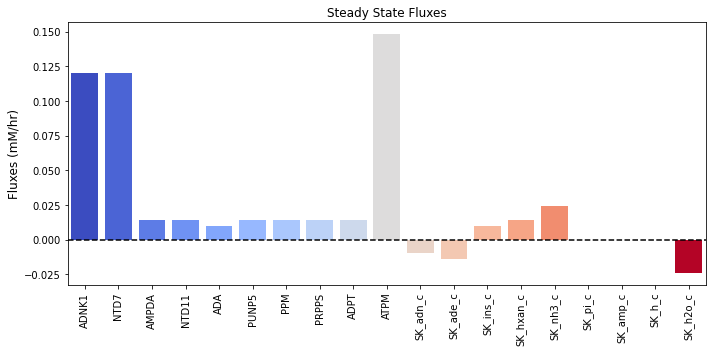

In [15]:
fig_12_3, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# Define indicies for bar chart
indicies = np.arange(len(reaction_ids))+0.5
# Define colors to use
c = plt.cm.coolwarm(np.linspace(0, 1, len(reaction_ids)))
# Plot bar chart
ax.bar(indicies, list(ssfluxes.values()), width=0.8, color=c);
ax.set_xlim([0, len(reaction_ids)]);
# Set labels and adjust ticks
ax.set_xticks(indicies);
ax.set_xticklabels(reaction_ids, rotation="vertical");
ax.set_ylabel("Fluxes (mM/hr)", L_FONT);
ax.set_title("Steady State Fluxes", L_FONT);
# Add a dashed line at 0 
ax.plot([0, len(reaction_ids)], [0, 0], "k--");
fig_12_3.tight_layout()

**Figure 12.3:** Bar chart of the steady-state fluxes.

We can perform a numerical check make sure that we have a steady state flux vector by performing the multiplication $\textbf{Sv}_{\mathrm{stst}}$ that should yield zero.

**A numerical QC/QA:** Ensure $\textbf{Sv}_{\mathrm{stst}} = 0$

In [16]:
pd.DataFrame(
    ampsn.S.dot(np.array(list(ssfluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"],
    dtype=np.int64).T

adn_c  ade_c  imp_c  ins_c  hxan_c  r1p_c  \
$\textbf{Sv}_{\mathrm{stst}}$      0      0      0      0       0      0   

                               r5p_c  prpp_c  atp_c  adp_c  amp_c  pi_c  \
$\textbf{Sv}_{\mathrm{stst}}$      0       0      0      0      0     0   

                               nh3_c  h_c  h2o_c  
$\textbf{Sv}_{\mathrm{stst}}$      0    0      0

### Computing the PERCs  
The approximate steady state values of the metabolites are given above. The mass action ratios can be computed from these steady state concentrations.  We can also compute the forward rate constant for the reactions:

In [17]:
percs = ampsn.calculate_PERCs(update_reactions=True)

**Table 12.9:** AMP Salvage Network enzymes, loads, transport rates, and their abbreviations. For irreversible reactions, the numerical value for the equilibrium constants is $\infty$, which, for practical reasons, can be set to a finite value.

In [18]:
# Get concentration values for substitution into sympy expressions
value_dict = {sym.Symbol(str(met)): ic 
              for met, ic in ampsn.initial_conditions.items()}
value_dict.update({sym.Symbol(str(met)): bc 
                   for met, bc in ampsn.boundary_conditions.items()})

table_12_9 = []
# Get symbols and values for table and substitution
for p_key in ["Keq", "kf"]:
    symbol_list, value_list = [], []
    for p_str, value in ampsn.parameters[p_key].items():
        symbol_list.append(r"$%s_{\text{%s}}$" % (p_key[0], p_str.split("_", 1)[-1]))
        value_list.append("{0:.3f}".format(value) if value != INF else r"$\infty$")
        value_dict.update({sym.Symbol(p_str): value})
    table_12_9.extend([symbol_list, value_list])

table_12_9.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(ampsn.get_mass_action_ratios()).values()])
table_12_9.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(ampsn.get_disequilibrium_ratios()).values()])
table_12_9 = pd.DataFrame(np.array(table_12_9).T, index=reaction_ids,
                          columns=[r"$K_{eq}$ Symbol", r"$K_{eq}$ Value", "PERC Symbol", 
                                   "PERC Value", r"$\Gamma$", r"$\Gamma/K_{eq}$"])
table_12_9

$K_{eq}$ Symbol $K_{eq}$ Value             PERC Symbol  \
ADNK1          $K_{\text{ADNK1}}$       $\infty$      $k_{\text{ADNK1}}$   
NTD7            $K_{\text{NTD7}}$       $\infty$       $k_{\text{NTD7}}$   
AMPDA          $K_{\text{AMPDA}}$       $\infty$      $k_{\text{AMPDA}}$   
NTD11          $K_{\text{NTD11}}$       $\infty$      $k_{\text{NTD11}}$   
ADA              $K_{\text{ADA}}$       $\infty$        $k_{\text{ADA}}$   
PUNP5          $K_{\text{PUNP5}}$          0.090      $k_{\text{PUNP5}}$   
PPM              $K_{\text{PPM}}$         13.300        $k_{\text{PPM}}$   
PRPPS          $K_{\text{PRPPS}}$       $\infty$      $k_{\text{PRPPS}}$   
ADPT            $K_{\text{ADPT}}$       $\infty$       $k_{\text{ADPT}}$   
ATPM            $K_{\text{ATPM}}$       $\infty$       $k_{\text{ATPM}}$   
SK_adn_c    $K_{\text{SK_adn_c}}$          1.000   $k_{\text{SK_adn_c}}$   
SK_ade_c    $K_{\text{SK_ade_c}}$          1.000   $k_{\text{SK_ade_c}}$   
SK_ins_c    $K_{\text{SK_ins_c}}$          1.000   $k_{\text{SK_ins_c}}$   
SK_hxan_c  $K_{\text{SK_hxan_c}}$          1.000  $k_{\text{SK_hxan_c}}$   
SK_nh3_c    $K_{\text{SK_nh3_c}}$          1.000   $k_{\text{SK_nh3_c}}$   
SK_pi_c      $K_{\text{SK_pi_c}}$          1.000    $k_{\text{SK_pi_c}}$   
SK_amp_c    $K_{\text{SK_amp_c}}$          1.000   $k_{\text{SK_amp_c}}$   
SK_h_c        $K_{\text{SK_h_c}}$          1.000     $k_{\text{SK_h_c}}$   
SK_h2o_c    $K_{\text{SK_h2o_c}}$          1.000   $k_{\text{SK_h2o_c}}$   

           PERC Value       $\Gamma$ $\Gamma/K_{eq}$  
ADNK1          62.500      13.099557        0.000000  
NTD7            1.384       0.034591        0.000000  
AMPDA           0.161       0.010493        0.000000  
NTD11           1.400       0.250000        0.000000  
ADA             8.333       0.075835        0.000000  
PUNP5          12.000       0.048000        0.533333  
PPM             0.235       0.082333        0.006190  
PRPPS           1.107       0.033251        0.000000  
ADPT         2800.000  108410.125000        0.000000  
ATPM            0.204       2.206897        0.000000  
SK_adn_c   100000.000       1.000000        1.000000  
SK_ade_c   100000.000       1.000000        1.000000  
SK_ins_c   100000.000       1.000000        1.000000  
SK_hxan_c  100000.000       1.000000        1.000000  
SK_nh3_c   100000.000       1.000000        1.000000  
SK_pi_c    100000.000       1.000000        1.000000  
SK_amp_c   100000.000       1.000000        1.000000  
SK_h_c     100000.000       1.000000        1.000000  
SK_h2o_c   100000.000       1.000000        1.000000

These estimates for the numerical values for the PERCs are shown in Table 12.9. These numerical values, along with the elementary form of the rate laws, complete the definition of the dynamic mass balances that can now be simulated. The steady state is specified in Table 12.8.

### Ratios  
The AMP degradation and biosynthetic pathways determine the amount of AMP and its degradation products present. We thus define the 'AMP charge,' calculated as the AMP concentration divided by the concentration of AMP and its degradation. This pool consists of IMP, ADO, INO, R1P, R5P, and PRPP. The AMP charge is 

$$\begin{equation} r_{\text{AMP}} = \frac{\text{AMP}}{\text{AMP} + \text{IMP} + \text{ADO} + \text{INO} + \text{R1P} + \text{R5P} + \text{PRPP}} \end{equation}$$

The AMP charge, $r_{AMP}$, is a little over 50% at steady-state calculated below. Thus, about half of the pentose in the system is in the AMP molecule and the other half is in the degradation or biosynthesis products. 

### Dynamic simulation: Increasing AMP concentration
The maintenance of AMP at a physiologically meaningful value is determined by the balance of its degradative and biosynthetic pathways. In Chapter 10 we saw that a disturbance in the ATP load on glycolysis leads to AMP exiting the glycolytic system, requiring degradation. Here we are interested in seeing how the balance of the AMP pathways is influenced by a sudden change in the level of AMP. 

We thus simulate the response to a sudden 10% increase in AMP concentration as a proxy for a disturbance that increases AMP concentration, such as the simulations performed in the previous chapters. 

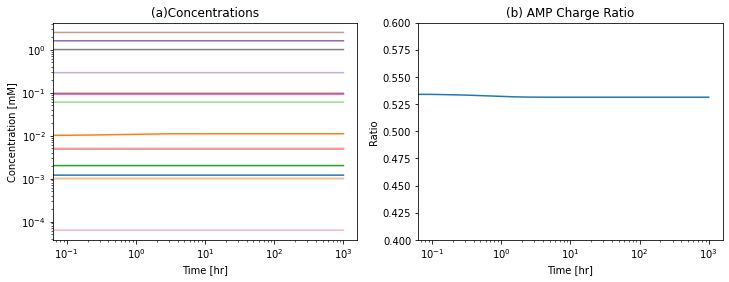

In [19]:
t0, tf = (0, 1000)
sim_ampsn = Simulation(ampsn)
conc_sol, flux_sol = sim_ampsn.simulate(
    ampsn, time=(t0, tf, tf*10 + 1),
    perturbations={"amp_b": "amp_b * 1.1"})

conc_sol.make_aggregate_solution(
    "AMP_Charge_Ratio",
    equation="(amp_c) / (amp_c + adn_c + ade_c + imp_c + ins_c + prpp_c + r1p_c + r5p_c)")

fig_12_4, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, observable=ampsn.metabolites, ax=ax1,
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Concentration [mM]",
    title=("(a)Concentrations", L_FONT));

plot_time_profile(
    conc_sol, observable="AMP_Charge_Ratio", ax=ax2,
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Ratio", ylim=(0.4, .6),
    title=("(b) AMP Charge Ratio", L_FONT));
fig_12_3.tight_layout()

**Figure 12.4:** (a) The concentrations of the AMP metabolism pathway and (b) The AMP charge after a sudden 10% increase in the AMP concentration at $t=0$.

The response of the degradation pathways to AMP increase is a rapid conversion of AMP to IMP followed by a slow conversion of IMP to INO that is then rapidly exchanged with plasma, Figure 12.5. This degradation route is kinetically preferred. A sudden decrease in AMP has similar, but opposite responses. If AMP is suddenly reduced in concentration, the flux through this pathway drops. 

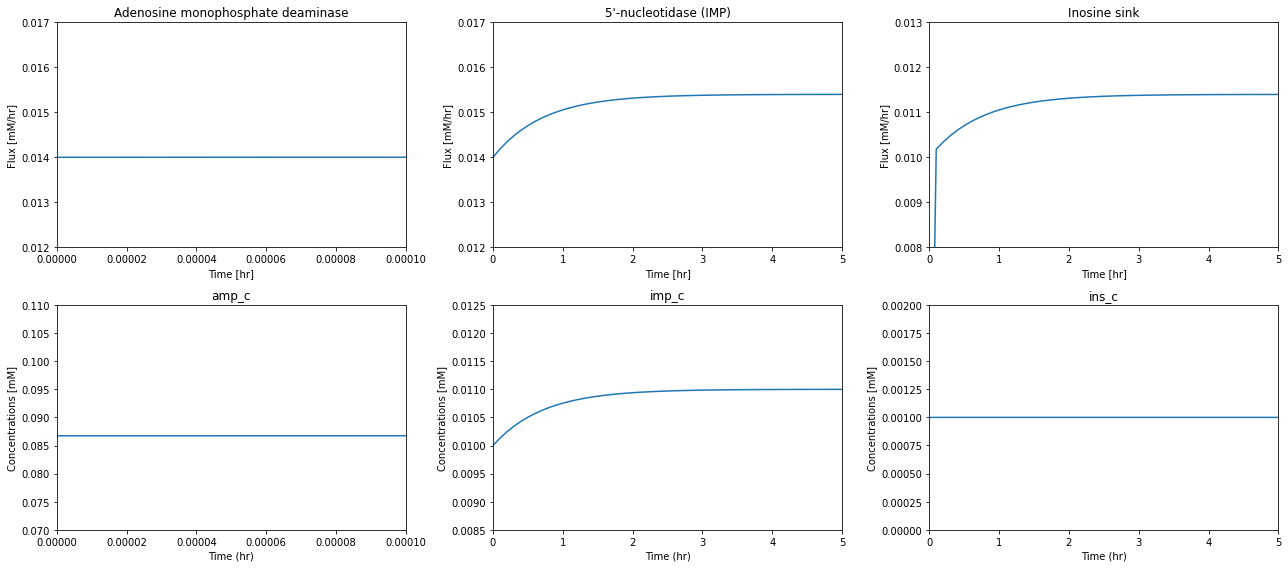

In [20]:
fig_12_5, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

ylims = [
    [(0.012, 0.017), (0.012, 0.017), (0.008, 0.013)],
    [(0.07, 0.11),(0.0085, 0.0125),(0.000, 0.002)]
]

for i, [rxn, met] in enumerate(zip(["AMPDA", "NTD11", "SK_ins_c"],
                                   ["amp_c", "imp_c", "ins_c"])):
    xlims = (t0, 5/50000) if i == 0 else (t0, 5)
    plot_time_profile(
        flux_sol, observable=rxn, ax=axes[0][i],
        xlim=xlims, ylim=ylims[0][i],
        xlabel="Time [hr]", ylabel="Flux [mM/hr]",
        title=(ampsn.reactions.get_by_id(rxn).name, L_FONT))

    plot_time_profile(
        conc_sol, observable=met, ax=axes[1][i],
        xlim=xlims, ylim=ylims[1][i],
        xlabel="Time (hr)", ylabel="Concentrations [mM]",
        title=(met, L_FONT))
fig_12_5.tight_layout()

**Figure 12.5:** The dynamic response of the AMP synthesis/degradation sub-network to a sudden 10% increase in the AMP concentration at $t=0$. The most notable set of fluxes are shown.

## Network Integration  
The AMP metabolic sub-network of Figure 12.1 can be integrated with the glycolysis and pentose pathway network from the last chapter. The result is shown in Figure 12.6. This integrated network represents the core of the metabolic network in the red blood cell, the simplest cell in the human body. 

![Figure-12-6](../images/Ch12/Figure-12-6.png)

**Figure 12.6:** The core metabolic network in the human red blood cell comprised of glycolysis, the pentose pathway, and adenine nucleotide metabolism. Some of the integration issues discussed in the text are highlighted with dashed ovals.

### Integration issues  
Given the many points of contact created between the AMP sub-network and the combined glycolytic and pentose pathway network, there are a few interesting integration issues. They are highlighted with dashed ovals in Figure 12.6 and are as follows: 

* The AMP molecule in the two networks connects the two. These two nodes need to be merged into one.

* The R5P molecule appears in both the AMP metabolic subnetwork and the pentose pathway, so these two nodes also need to be merged. 

* In the sub-network described above, the stoichiometry of the PRPP synthase reaction is 
    $$\begin{equation} \text{R5P} + 2\text{ATP} \rightarrow \text{PRPP} + 2\text{ADP} + \text{H} \tag{12.2} \end{equation}$$

    but in actuality it is 
 
    $$\begin{equation} \text{R5P} + \text{ATP} \rightarrow \text{PRPP} + \text{AMP} + \text{H} \tag{12.3} \end{equation}$$

    this difference disappears since the ApK reaction is in the combined glycolytic and pentose pathway network: 
 
    $$\begin{equation} \text{AMP} + \text{ATP} \leftrightharpoons 2\text{ADP} \tag{12.4} \end{equation}$$

    i.e., if Equations (12.3) and (12.4) are added, one gets Eq. (12.2).

* The ATP cost of driving the biosynthetic pathways to AMP is now a part of the ATP load in the integrated model. 

* The AMP exchange reaction disappears, and instead we now have exchange reactions for ADO, ADE, INO, and HYP, and the deamination reactions create an exchange flux for $\text{NH}_3$. 

### Merging the models
Just as in the last chapter, we start by loading all the models, and then combine them:

In [21]:
glycolysis = create_example_model("SB2_Glycolysis")
ppp = create_example_model("SB2_PentosePhosphatePathway")
ampsn = create_example_model("SB2_AMPSalvageNetwork")

fullppp = glycolysis.merge(ppp, inplace=False)
fullppp.id = "Full_PPP"
fullppp.remove_reactions([
    r for r in fullppp.boundary 
    if r.id in ["SK_g6p_c", "DM_f6p_c", "DM_g3p_c", "DM_r5p_c"]])
fullppp.remove_boundary_conditions(["g6p_b", "f6p_b", "g3p_b", "r5p_b"])
core_network = fullppp.merge(ampsn, inplace=False)
core_network.id = "Core_Model"

Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.
Ignoring reaction 'ATPM' since it already exists.
Ignoring reaction 'SK_amp_c' since it already exists.
Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.


Then a few obsolete exchange reactions have to be removed.

In [22]:
for boundary in core_network.boundary:
    print(boundary)

DM_amp_c: amp_c --> 
SK_pyr_c: pyr_c <=> 
SK_lac__L_c: lac__L_c <=> 
SK_glc__D_c:  <=> glc__D_c
SK_amp_c:  <=> amp_c
SK_h_c: h_c <=> 
SK_h2o_c: h2o_c <=> 
SK_co2_c: co2_c <=> 
SK_adn_c: adn_c <=> 
SK_ade_c: ade_c <=> 
SK_ins_c: ins_c <=> 
SK_hxan_c: hxan_c <=> 
SK_nh3_c: nh3_c <=> 
SK_pi_c: pi_c <=> 


In [23]:
core_network.remove_reactions([
    r for r in core_network.boundary 
    if r.id in ["DM_amp_c", "SK_amp_c"]])
core_network.remove_boundary_conditions(["amp_b"])

We then need to change the PRPP synthesis reaction to have the correct stoichiometry and PERC:

In [24]:
# Note that reactants have negative coefficients and products have positive coefficients
core_network.reactions.PRPPS.subtract_metabolites({
    core_network.metabolites.atp_c: -1,
    core_network.metabolites.adp_c: 2})
core_network.reactions.PRPPS.add_metabolites({
    core_network.metabolites.amp_c: 1})

The merged model contains 40 metabolites and 45 reactions:

In [25]:
print(core_network.S.shape)

(40, 45)


Note that the merged model is not in a steady-state:

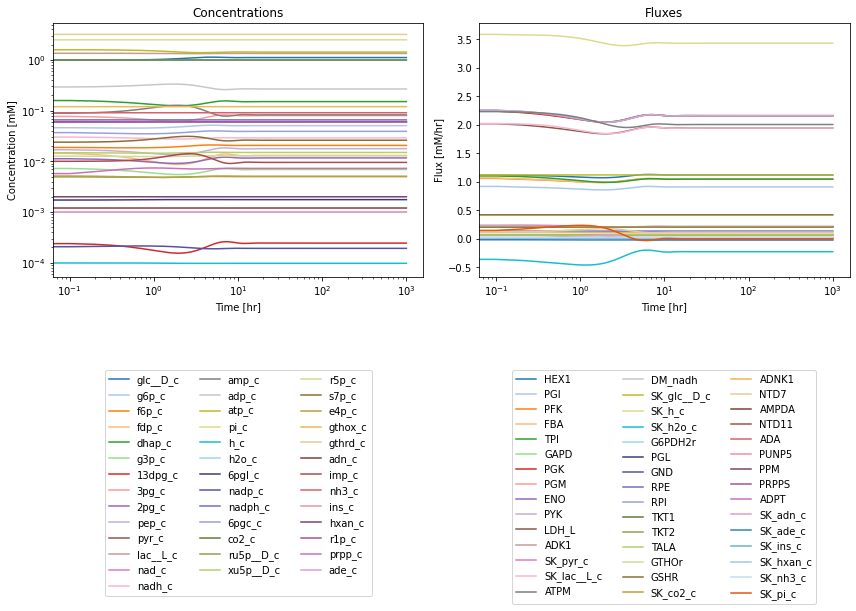

In [26]:
t0, tf = (0, 1e3)
sim_core = Simulation(core_network)
conc_sol, flux_sol = sim_core.simulate(
    core_network, time=(t0, tf, tf*10 + 1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="lower outside", 
    plot_function="loglog", xlabel="Time [hr]", 
    ylabel="Concentration [mM]", title=("Concentrations", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="lower outside", 
    plot_function="semilogx", xlabel="Time [hr]", 
    ylabel="Flux [mM/hr]", title=("Fluxes", L_FONT));
fig.tight_layout()

### Organization of the stoichiometric matrix
As in the previous chapter, we can perform a set of transformations to group the species and reactions into organized groups.  

In [27]:
# Define new order for metabolites
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c", 
    "g3p_c", "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", 
    "pyr_c", "lac__L_c", "_6pgl_c", "_6pgc_c", "ru5p__D_c", 
    "xu5p__D_c", "r5p_c", "s7p_c", "e4p_c", "ade_c", "adn_c", 
    "imp_c", "ins_c", "hxan_c", "r1p_c", "prpp_c", "nad_c", 
    "nadh_c",  "amp_c", "adp_c", "atp_c", "nadp_c", "nadph_c", 
    "gthrd_c", "gthox_c", "pi_c", "h_c", "h2o_c", "co2_c", "nh3_c"]
if len(core_network.metabolites) == len(new_metabolite_order):
    core_network.metabolites = DictList(core_network.metabolites.get_by_any(new_metabolite_order))
# Define new order for reactions
new_reaction_order = [
    "HEX1", "PGI", "PFK", "FBA", "TPI", "GAPD", "PGK", "PGM", 
    "ENO", "PYK", "LDH_L", "G6PDH2r", "PGL", "GND", "RPE", 
    "RPI", "TKT1", "TKT2", "TALA", "ADNK1", "NTD7", "ADA","AMPDA", 
    "NTD11", "PUNP5", "PPM", "PRPPS", "ADPT", "ADK1", 
    "ATPM", "DM_nadh", "GTHOr", "GSHR", "SK_glc__D_c", "SK_pyr_c", 
    "SK_lac__L_c", "SK_ade_c", "SK_adn_c", "SK_ins_c", "SK_hxan_c",
    "SK_pi_c", "SK_h_c", "SK_h2o_c", "SK_co2_c", "SK_nh3_c"]
if len(core_network.reactions) == len(new_reaction_order):
    core_network.reactions = DictList(core_network.reactions.get_by_any(new_reaction_order))

The stoichiometric matrix for the merged core network model is shown in Table 11.11. This matrix has dimensions of 40x45 and its rank is 37. The null is of dimension 8 (=45-37) and the left null space is of dimension 3 (=40-37). The matrix is elementally balanced. 

We have used colors in Table 12.10 to illustrate the organized structure of the matrix. 

**Table 12.10:** The stoichiometric matrix for the merged core network model in Figure 12.6. The matrix is partitioned to show the glycolytic reactions (yellow)  separate from the pentose phosphate pathway (light blue) and the AMP salvage network (light green). The cofactors (light orange) and inorganics (pink) are also grouped and shown. The connectivities, $\rho_i$ (red), for a compound, and the participation number, $\pi_j$ (cyan), for a reaction are shown. The second block in the table is the product $\textbf{ES}$ (blue) to evaluate elemental balancing status of the reactions. All exchange reactions have a participation number of unity and are thus not elementally balanced. The last block in the table has the 8 pathway vectors (purple) for the merged model.  These vectors are graphically shown in Figure 12.7. Furthest to the right, we display the time invariant pools (green) that span the left null space.

In [28]:
# Define labels
metabolite_ids = [m.id for m in core_network.metabolites]
reaction_ids = [r.id for r in core_network.reactions]

pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', '[NAD]', '[NADP]']
time_inv_labels = [
    "$N_{\mathrm{tot}}$", "$NP_{\mathrm{tot}}$", "$G_{\mathrm{tot}}$"]
path_labels = ["$p_1$", "$p_2$", "$p_3$", "$p_4$", 
               "$p_5$", "$p_6$", "$p_7$", "$p_8$"]

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = core_network.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = core_network.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 1, 0, 0, 0, 0, 0,-2, 0, 0, 0],
    [1,-2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 1, 0, 1, 0, 0, 0, 0, 0,13,-3, 3, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,-1,-3, 0, 2, 2, 1, 0, 0,-1, 1, 0, 0, 0, 4, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,-1,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,-1,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,-1,-2, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0,-1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
table_12_10 = np.vstack((S_matrix, pi, ES_matrix, minspan_paths))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_12_10) - len(metabolite_ids))
rho = np.concatenate((rho, blanks))

lns = np.zeros((3, 40), dtype=np.int64)
lns[0][26:28] = 1
lns[1][31:33] = 1
lns[2][33] = 1
lns[2][34] = 2

time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_12_10 = np.vstack([table_12_10.T, rho, time_inv]).T

colors = {"glycolysis": "#ffffe6",    # Yellow
          "ppp": "#e6faff",           # Light blue
          "ampsn": "#d9fad2",
          "cofactor": "#ffe6cc",
          "inorganic": "#fadffa",
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
cofactor_mets = ["nad_c", "nadh_c",  "amp_c", "adp_c", "atp_c", 
                 "nadp_c", "nadph_c", "gthrd_c", "gthox_c"]
exch_misc_rxns= ["S_glc__D_e", "EX_pyr_e", "EX_lac__L_e", "EX_ade_e", "EX_adn_e",
                 "EX_ins_e", "EX_hxan_e", "ATPM", "DM_nadh", "GTHOr", "GSHR"]
inorganic_mets = ["pi_c", "h_c", "h2o_c", "co2_c", "nh3_c"]
inorganic_exch = ["EX_pi_e", "EX_h_e", "EX_h2o_e", "EX_co2_e", "EX_nh3_e"]

def highlight_table(df, model):
    df = df.copy()     
    condition = lambda mmodel, row, col, c1, c2:  (
        (col not in exch_misc_rxns + inorganic_exch) and (row not in cofactor_mets + inorganic_mets) and (
            (row in mmodel.metabolites and c1) or (col in mmodel.reactions or c2)))
    inorganic_condition = lambda row, col: (col in inorganic_exch or row in inorganic_mets)
    for i, row in enumerate(df.index):
        for j, col in enumerate(df.columns):
            if df.loc[row, col] == "":
                main_key = "blank"
            elif row in pi_str:
                main_key = "pi"
            elif row in chopsnq:
                main_key = "chopsnq"
            elif row in path_labels:
                main_key = "pathways"
            elif col in rho_str:
                main_key = "rho"
            elif col in time_inv_labels:
                main_key = "time_invs"
            elif condition(ampsn, row, col, row not in ["r5p_c"], col in ["ADK1"]):
                main_key = "ampsn"
            elif condition(ppp, row, col, row not in ["g6p_c", "f6p_c", "g3p_c"], False):
                main_key = "ppp"
            elif condition(glycolysis, row, col, True, False):
                main_key = "glycolysis"
            elif ((col in exch_misc_rxns or row in cofactor_mets) and not inorganic_condition(row, col)):
                main_key = "cofactor"
            elif inorganic_condition(row, col):
                main_key = "inorganic"
            else:
                continue
            df.loc[row, col] = bg_color_str + colors[main_key]  
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_12_10 = pd.DataFrame(
    table_12_10, index=index_labels, columns=column_labels)
# Apply colors
table_12_10 = table_12_10.style.apply(
    highlight_table,  model=core_network, axis=None)
table_12_10

### The pathway structure:

![Figure-12-7](../images/Ch12/Figure-12-7.png)

**Figure 12.7:** Pathway maps for the eight pathway vectors for the system formed by coupling glycolysis, the pentose pathway, and the AMP Salvage Network. (From left to right, top to bottom, $\textbf{p}_1$ through $\textbf{p}_8$). They span all possible steady state solutions.

There are eight pathway vectors, shown in Table 12.10, that are chosen to match those used above and in the previous chapter. $\textbf{p}_1$ is the glycolytic pathway to lactate secretion, $\textbf{p}_2$ is the pyruvate-lactate exchange coupled to the NADH cofactor, and $\textbf{p}_3$ is the pentose pathway cycle to $\text{CO}_2$ formation producing NADPH. These are the same pathways as above. In the last chapter we had AMP exchange that now couples to the five AMP degradation and salvage pathways that form in the AMP metabolic sub-network. They are as follows: 

1. $\textbf{p}_4$ is a complicated pathway that imports glucose that is processed through the pentose pathway to form R5P and the formation of $\text{CO}_2$. R5P is then combined with an imported adenine to form AMP that then goes through the degradation pathway to adenosine that is secreted. This pathway is a balanced use of the whole network and represents a combination of the AMP biosynthetic and degradation pathways. This pathway corresponds to $\textbf{p}_1$ in the AMP sub-network. 

2. $\textbf{p}_5$ is a similar pathway as $\textbf{p}_4$ above but producing inosine, and it corresponds to $\textbf{p}_2$ in the AMP sub-network. Inosine is produced from AMP by first dephosphorylation to adenosine followed by deamination to inosine. 

3. $\textbf{p}_6$ is a similar pathway as $\textbf{p}_4$ above but producing inosine, and it corresponds to $\textbf{p}_3$ in the AMP sub-network. Inosine is produced from AMP by first deamination to IMP followed by dephosphorylation to inosine; the same effect as in $\textbf{p}_5$, but in the opposite order. 

4. $\textbf{p}_7$ is the salvage pathway that has a net import of adenine and secreting hypoxanthine with a deamination step. 

5. $\textbf{p}_8$ is a futile cycle that consumes ATP through the simultaneous use of ADNK1 and NTD7. 

As we saw with the integration of glycolysis and the pentose pathway, the incorporation of the AMP sub-network creates new network-wide pathways. These network-based pathway definitions further show how historical definitions of pathways give way to full network considerations as we form pathways for the entire system. Again, this feature is of great importance to systems biology (Papin 2003, _Systems Biology: Properties of Reconstructed Networks_). 

### Structure of the stoichiometric matrix  
The matrix can be organized by pathway and metabolic processes. The dashed lines in Table 12.10 divide the matrix up into blocks. Each block in this formulation shows how the metabolites and reactions are coupled. These diagonal blocks describe the metabolites and reactions in each sub-network. 

The upper off-diagonal blocks, for instance, show how the metabolites, cofactors and exchanges affect the metabolites in each pathway or sub-network represented on the diagonal. The lower off-diagonal blocks show how the metabolites, cofactors and exchanges participate in the reaction in each pathway or sub-network that is represented by the corresponding block on the diagonal. 

## Defining the Steady State

The null space is eight dimensional and we have to specify eight fluxes to fix the steady state. Following the previous chapters and what is given above, we specify: $v_{S_{\textit{glc__D}}} = 1.12$, $v_{DM_{nadh}}=0.2*v_{S_{\textit{glc__D}}}$, $v_{GSHR}=0.42$, $v_{SK_{ade}}=-0.014$, $v_{ADA}=0.01$, $v_{SK_{adn}}=0.01$, $v_{ADNK1}=0.12$, and $v_{SK_{hxan}} = 0.097$ using earlier models and specifying independent fluxes in the pathway vectors. 

In [29]:
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {
    core_network.reactions.SK_glc__D_c: 1.12, 
    core_network.reactions.DM_nadh: 0.2*1.12, 
    core_network.reactions.GSHR : 0.42, 
    core_network.reactions.SK_ade_c: -0.014, 
    core_network.reactions.ADA: 0.01,
    core_network.reactions.SK_adn_c: -0.01, 
    core_network.reactions.ADNK1: 0.12, 
    core_network.reactions.SK_hxan_c: 0.097}

ssfluxes = core_network.compute_steady_state_fluxes(
    minspan_paths,
    independent_fluxes,
    update_reactions=True)
table_12_11 = pd.DataFrame(list(ssfluxes.values()), index=reaction_ids, 
                           columns=[r"$\textbf{v}_{\mathrm{stst}}$"]).T

**Table 12.11:**	The steady state fluxes as a summation of the MinSpan pathway vectors.

In [30]:
table_12_11

HEX1   PGI   PFK   FBA   TPI  GAPD   PGK   PGM  \
$\textbf{v}_{\mathrm{stst}}$ 1.120 0.910 1.105 1.105 1.105 2.308 2.308 2.308   

                               ENO   PYK  LDH_L  G6PDH2r   PGL   GND   RPE  \
$\textbf{v}_{\mathrm{stst}}$ 2.308 2.308  2.084    0.210 0.210 0.210 0.195   

                               RPI  TKT1  TKT2  TALA  ADNK1  NTD7   ADA  \
$\textbf{v}_{\mathrm{stst}}$ 0.015 0.098 0.098 0.098  0.120 0.120 0.010   

                              AMPDA  NTD11  PUNP5   PPM  PRPPS  ADPT   ADK1  \
$\textbf{v}_{\mathrm{stst}}$  0.014  0.014  0.097 0.097  0.014 0.014 -0.014   

                              ATPM  DM_nadh  GTHOr  GSHR  SK_glc__D_c  \
$\textbf{v}_{\mathrm{stst}}$ 2.243    0.224  0.420 0.420        1.120   

                              SK_pyr_c  SK_lac__L_c  SK_ade_c  SK_adn_c  \
$\textbf{v}_{\mathrm{stst}}$     0.224        2.084    -0.014    -0.010   

                              SK_ins_c  SK_hxan_c  SK_pi_c  SK_h_c  SK_h2o_c  \
$\textbf{v}_{\mathrm{stst}}$    -0.073      0.097    0.000   3.596    -0.317   

                              SK_co2_c  SK_nh3_c  
$\textbf{v}_{\mathrm{stst}}$     0.210     0.024

These vectors can be visualized as a bar chart:

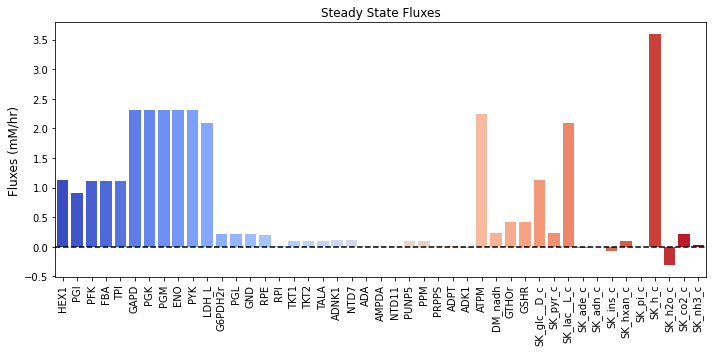

In [31]:
fig_12_8, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# Define indicies for bar chart
indicies = np.arange(len(reaction_ids))+0.5
# Define colors to use
c = plt.cm.coolwarm(np.linspace(0, 1, len(reaction_ids)))
# Plot bar chart
ax.bar(indicies, list(ssfluxes.values()), width=0.8, color=c);
ax.set_xlim([0, len(reaction_ids)]);
# Set labels and adjust ticks
ax.set_xticks(indicies);
ax.set_xticklabels(reaction_ids, rotation="vertical");
ax.set_ylabel("Fluxes (mM/hr)", L_FONT);
ax.set_title("Steady State Fluxes", L_FONT);
ax.plot([0, len(reaction_ids)], [0, 0], "k--");
fig_12_8.tight_layout()

**Figure 12.8:** Bar chart of the steady-state fluxes.

 **A numerical QC/QA:** Ensure $\textbf{Sv}_{\mathrm{stst}} = 0$

In [32]:
pd.DataFrame(
    core_network.S.dot(np.array(list(ssfluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"],
    dtype=np.int64).T

glc__D_c  g6p_c  f6p_c  fdp_c  dhap_c  g3p_c  \
$\textbf{Sv}_{\mathrm{stst}}$         0      0      0      0       0      0   

                               _13dpg_c  _3pg_c  _2pg_c  pep_c  pyr_c  \
$\textbf{Sv}_{\mathrm{stst}}$         0       0       0      0      0   

                               lac__L_c  _6pgl_c  _6pgc_c  ru5p__D_c  \
$\textbf{Sv}_{\mathrm{stst}}$         0        0        0          0   

                               xu5p__D_c  r5p_c  s7p_c  e4p_c  ade_c  adn_c  \
$\textbf{Sv}_{\mathrm{stst}}$          0      0      0      0      0      0   

                               imp_c  ins_c  hxan_c  r1p_c  prpp_c  nad_c  \
$\textbf{Sv}_{\mathrm{stst}}$      0      0       0      0       0      0   

                               nadh_c  amp_c  adp_c  atp_c  nadp_c  nadph_c  \
$\textbf{Sv}_{\mathrm{stst}}$       0      0      0      0       0        0   

                               gthrd_c  gthox_c  pi_c  h_c  h2o_c  co2_c  \
$\textbf{Sv}_{\mathrm{stst}}$        0        0     0    0      0      0   

                               nh3_c  
$\textbf{Sv}_{\mathrm{stst}}$      0

### Computing the rate constants  
The kinetic constants can be computed from the steady state values of the concentrations using elementary mass action kinetics. The computation is based on Eq. (10.4) The results from this computation is summarized in Table 12.12. This table has all the reaction properties that we need to complete the MASS model.

In [33]:
percs = core_network.calculate_PERCs(
    fluxes={
        r: flux for r, flux in core_network.steady_state_fluxes.items()
        if r.id != "ADK1"}, # Skip ADK1
    update_reactions=True)

**Table 12.12:** Combined glycolysis, pentose phosphate pathway, and AMP salvage network enzymes and transport rates.

In [34]:
# Get concentration values for substitution into sympy expressions
value_dict = {sym.Symbol(str(met)): ic 
              for met, ic in core_network.initial_conditions.items()}
value_dict.update({sym.Symbol(str(met)): bc 
                   for met, bc in core_network.boundary_conditions.items()})
table_12_12 = []
# Get symbols and values for table and substitution
for p_key in ["Keq", "kf"]:
    symbol_list, value_list = [], []
    for p_str, value in core_network.parameters[p_key].items():
        symbol_list.append(r"$%s_{\text{%s}}$" % (p_key[0], p_str.split("_", 1)[-1]))
        value_list.append("{0:.3f}".format(value) if value != INF else r"$\infty$")
        value_dict.update({sym.Symbol(p_str): value})
    table_12_12.extend([symbol_list, value_list])

table_12_12.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(core_network.get_mass_action_ratios()).values()])
table_12_12.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(core_network.get_disequilibrium_ratios()).values()])
table_12_12 = pd.DataFrame(np.array(table_12_12).T, index=reaction_ids,
                           columns=[r"$K_{eq}$ Symbol", r"$K_{eq}$ Value", "PERC Symbol", 
                                    "PERC Value", r"$\Gamma$", r"$\Gamma/K_{eq}$"])
table_12_12

$K_{eq}$ Symbol $K_{eq}$ Value  \
HEX1                $K_{\text{HEX1}}$        850.000   
PGI                  $K_{\text{PGI}}$          0.410   
PFK                  $K_{\text{PFK}}$        310.000   
FBA                  $K_{\text{FBA}}$          0.082   
TPI                  $K_{\text{TPI}}$          0.057   
GAPD                $K_{\text{GAPD}}$          0.018   
PGK                  $K_{\text{PGK}}$       1800.000   
PGM                  $K_{\text{PGM}}$          0.147   
ENO                  $K_{\text{ENO}}$          1.695   
PYK                  $K_{\text{PYK}}$     363000.000   
LDH_L              $K_{\text{LDH_L}}$      26300.000   
G6PDH2r          $K_{\text{G6PDH2r}}$       1000.000   
PGL                  $K_{\text{PGL}}$       1000.000   
GND                  $K_{\text{GND}}$       1000.000   
RPE                  $K_{\text{RPE}}$          3.000   
RPI                  $K_{\text{RPI}}$          2.570   
TKT1                $K_{\text{TKT1}}$          1.200   
TKT2                $K_{\text{TKT2}}$         10.300   
TALA                $K_{\text{TALA}}$          1.050   
ADNK1              $K_{\text{ADNK1}}$       $\infty$   
NTD7                $K_{\text{NTD7}}$       $\infty$   
ADA                  $K_{\text{ADA}}$       $\infty$   
AMPDA              $K_{\text{AMPDA}}$       $\infty$   
NTD11              $K_{\text{NTD11}}$       $\infty$   
PUNP5              $K_{\text{PUNP5}}$          0.090   
PPM                  $K_{\text{PPM}}$         13.300   
PRPPS              $K_{\text{PRPPS}}$       $\infty$   
ADPT                $K_{\text{ADPT}}$       $\infty$   
ADK1                $K_{\text{ADK1}}$          1.650   
ATPM                $K_{\text{ATPM}}$       $\infty$   
DM_nadh          $K_{\text{DM_nadh}}$       $\infty$   
GTHOr              $K_{\text{GTHOr}}$        100.000   
GSHR                $K_{\text{GSHR}}$          2.000   
SK_glc__D_c  $K_{\text{SK_glc__D_c}}$       $\infty$   
SK_pyr_c        $K_{\text{SK_pyr_c}}$          1.000   
SK_lac__L_c  $K_{\text{SK_lac__L_c}}$          1.000   
SK_ade_c        $K_{\text{SK_ade_c}}$          1.000   
SK_adn_c        $K_{\text{SK_adn_c}}$          1.000   
SK_ins_c        $K_{\text{SK_ins_c}}$          1.000   
SK_hxan_c      $K_{\text{SK_hxan_c}}$          1.000   
SK_pi_c          $K_{\text{SK_pi_c}}$          1.000   
SK_h_c            $K_{\text{SK_h_c}}$          1.000   
SK_h2o_c        $K_{\text{SK_h2o_c}}$          1.000   
SK_co2_c        $K_{\text{SK_co2_c}}$          1.000   
SK_nh3_c        $K_{\text{SK_nh3_c}}$          1.000   

                          PERC Symbol   PERC Value       $\Gamma$  \
HEX1                $k_{\text{HEX1}}$        0.700       0.008809   
PGI                  $k_{\text{PGI}}$     2961.111       0.407407   
PFK                  $k_{\text{PFK}}$       34.906       0.133649   
FBA                  $k_{\text{FBA}}$     2797.449       0.079781   
TPI                  $k_{\text{TPI}}$       33.906       0.045500   
GAPD                $k_{\text{GAPD}}$     3479.760       0.006823   
PGK                  $k_{\text{PGK}}$  1312381.554    1755.073081   
PGM                  $k_{\text{PGM}}$     5017.110       0.146184   
ENO                  $k_{\text{ENO}}$     1817.545       1.504425   
PYK                  $k_{\text{PYK}}$      468.247      19.570304   
LDH_L              $k_{\text{LDH_L}}$     1150.285      44.132974   
G6PDH2r          $k_{\text{G6PDH2r}}$    21864.589      11.875411   
PGL                  $k_{\text{PGL}}$      122.323      21.362698   
GND                  $k_{\text{GND}}$    29287.807      43.340651   
RPE                  $k_{\text{RPE}}$    22392.052       2.994699   
RPI                  $k_{\text{RPI}}$     2021.058       2.566222   
TKT1                $k_{\text{TKT1}}$     2338.070       0.932371   
TKT2                $k_{\text{TKT2}}$     1600.141       1.921130   
TALA                $k_{\text{TALA}}$     1237.363       0.575416   
ADNK1              $k_{\text{ADNK1}}$       62.500      13.099557

## Simulating the Dynamic Mass Balance
### Validating the steady state
As before, we must first ensure that the system is originally at steady state:

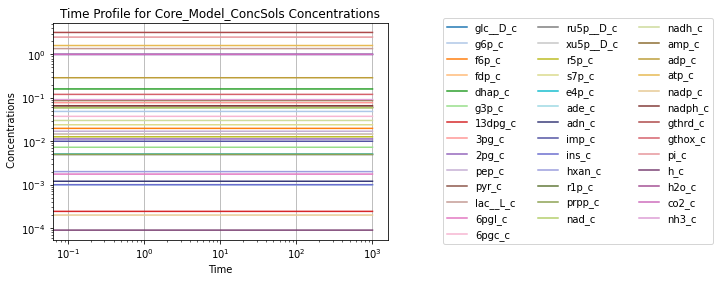

In [35]:
t0, tf = (0, 1e3)
sim_core = Simulation(core_network)
sim_core.find_steady_state(
    core_network, strategy="simulate",
    update_values=True)
conc_sol_ss, flux_sol_ss = sim_core.simulate(
    core_network, time=(t0, tf, tf*10 + 1))
# Quickly render and display time profiles 
conc_sol_ss.view_time_profile()

**Figure 12.9:** The merged model after determining the steady state conditions.

We can compare the differences in the initial state of each model before merging and after. 

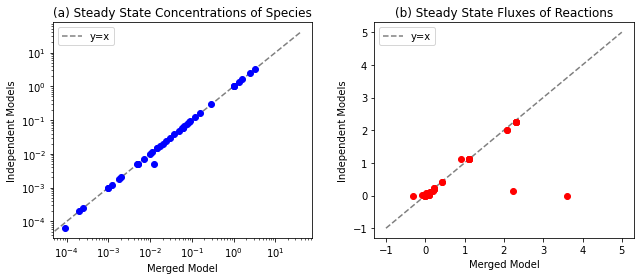

In [36]:
fig_12_10, axes = plt.subplots(1, 2, figsize=(9, 4))
(ax1, ax2) = axes.flatten()

# Compare initial conditions
initial_conditions = {
    m.id: ic for m, ic in glycolysis.initial_conditions.items()
    if m.id in core_network.metabolites}
initial_conditions.update({
    m.id: ic for m, ic in ppp.initial_conditions.items()
    if m.id in core_network.metabolites})
initial_conditions.update({
    m.id: ic for m, ic in ampsn.initial_conditions.items()
    if m.id in core_network.metabolites})

plot_comparison(
    core_network, pd.Series(initial_conditions), compare="concentrations",
    ax=ax1, plot_function="loglog",
    xlabel="Merged Model", ylabel="Independent Models",
    title=("(a) Steady State Concentrations of Species", L_FONT),
    color="blue", xy_line=True, xy_legend="best");

# Compare fluxes
fluxes = {
    r.id: flux for r, flux in glycolysis.steady_state_fluxes.items()
    if r.id in core_network.reactions}
fluxes.update({
    r.id: flux for r, flux in ppp.steady_state_fluxes.items()
    if r.id in core_network.reactions})
fluxes.update({
    r.id: flux for r, flux in ampsn.steady_state_fluxes.items()
    if r.id in core_network.reactions})

plot_comparison(
    core_network, pd.Series(fluxes), compare="fluxes", 
    ax=ax2, plot_function="plot",
    xlabel="Merged Model", ylabel="Independent Models",
    title=("(b) Steady State Fluxes of Reactions", L_FONT),
    color="red", xy_line=True, xy_legend="best");
fig_12_10.tight_layout()

**Figure 12.10:** Comparisons between the initial conditions of the merged model and the initial conditions of the independent glycolysis, pentose phosphate pathway, and AMP salvage networks for (a) the species and (b) the fluxes.

### Response to an increased $k_{ATPM}$
First, we must ensure that the system is originally at steady state. We perform the same simulation as in the last chapter by increasing the rate of ATP utilization. 

In [37]:
conc_sol, flux_sol = sim_core.simulate(
    core_network, time=(t0, tf, tf*10 + 1),
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"})

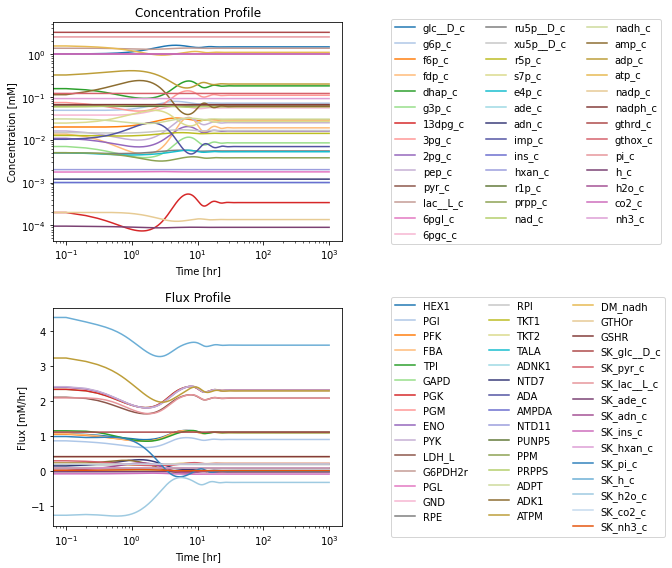

In [38]:
fig_12_11, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8));
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside", 
    plot_function="loglog", 
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));
fig_12_11.tight_layout()

**Figure 12.11:** Simulating the combined system from the steady state with 50% increase in the rate of ATP utilization at $t = 0$.

### Relative deviations from the initial state

As shown in the figure below, AMP still has the highest perturbation. Note that there is slightly more variation in the concentration profiles at around $t = 10$ than in combined glycolytic and pentose phosphate pathways. We can see that the flux deviations also follow the same general trend as the combined glycolysis and pentose phosphate pathway simulations, with slightly more variation.

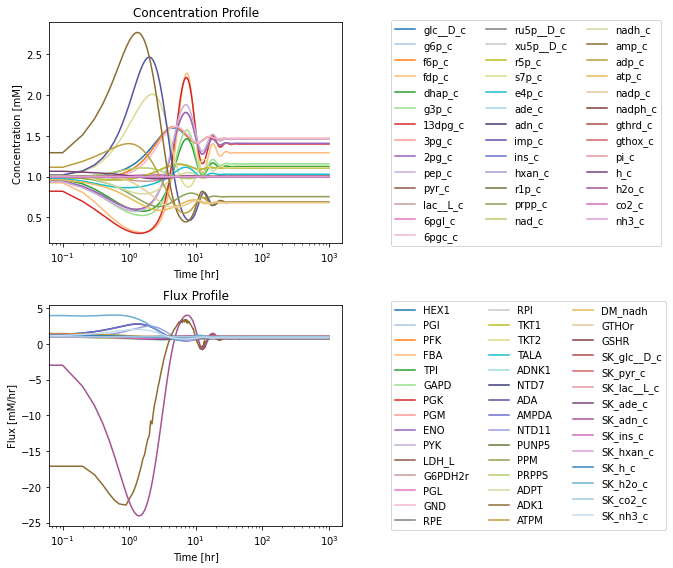

In [39]:
fig_12_12, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8));
(ax1, ax2) = axes.flatten()

conc_deviation = {met.id: conc_sol[met.id]/ic 
                  for met, ic in core_network.initial_conditions.items()}
conc_deviation = MassSolution(
    "Deviation", solution_type="Conc",
    data_dict=conc_deviation,
    time=conc_sol.t, interpolate=False)

flux_deviation = {rxn.id: flux_sol[rxn.id]/ssflux 
                  for rxn, ssflux in core_network.steady_state_fluxes.items()
                  if ssflux != 0} # To avoid dividing by 0 for equilibrium fluxes.

flux_deviation = MassSolution(
    "Deviation", solution_type="Flux",
    data_dict=flux_deviation, 
    time=flux_sol.t, interpolate=False)

plot_time_profile(
    conc_deviation, ax=ax1, legend="right outside", 
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_deviation, ax=ax2, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));
fig_12_12.tight_layout()

**Figure 12.12:** (a) Deviation from the steady state of the concentrations as a fraction of the steady state. (b) Deviation from the steady state of the fluxes as a fraction of the steady state.

### ATP Simulation Node Maps
As before, we will examine the node balances to gain a better understanding of the system's response.

#### The proton node
The proton node now has a connectivity of 15 with 11 production reactions and 4 utilization reactions. 

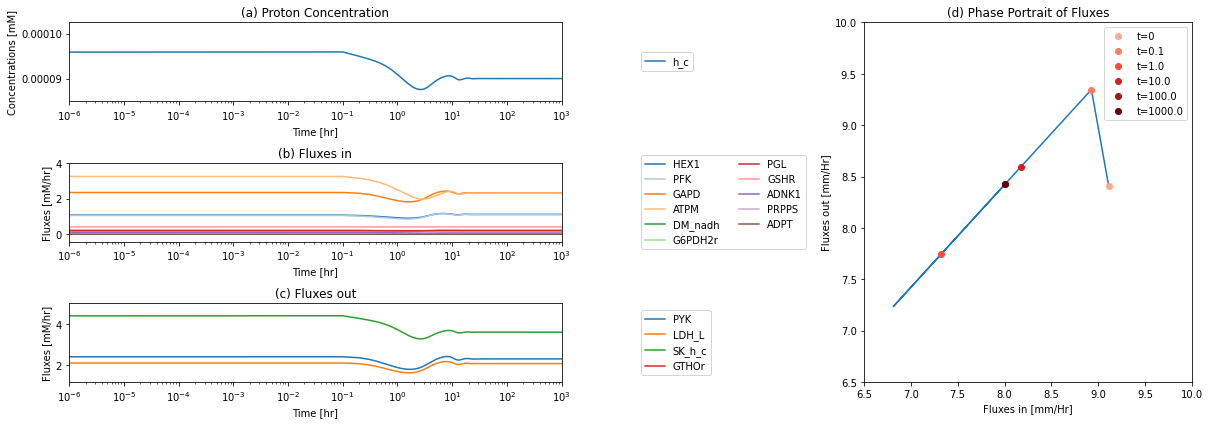

In [40]:
fig_12_13 = plt.figure(figsize=(17, 6))
gs = fig_12_13.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_12_13.add_subplot(gs[0, 0])
ax2 = fig_12_13.add_subplot(gs[1, 0])
ax3 = fig_12_13.add_subplot(gs[2, 0])
ax4 = fig_12_13.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="h_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(8.5e-5, 1e-4*1.025),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["HEX1", "PFK", "GAPD", "ATPM", "DM_nadh", 
             "G6PDH2r", "PGL", "GSHR", "ADNK1", "PRPPS", "ADPT"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(-0.4, 4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["PYK", "LDH_L","SK_h_c", "GTHOr"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(1.2, 5), 
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(6.5, 10), ylim=(6.5, 10),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");
fig_12_13.tight_layout()

**Figure 12.13:** The time profiles of the (a) proton concentration, (b) the fluxes that make protons, (c) the fluxes that use protons and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales) for an increase in ATP utilization.

#### The ATP Node
The ATP node now has a connectivity of 8. 

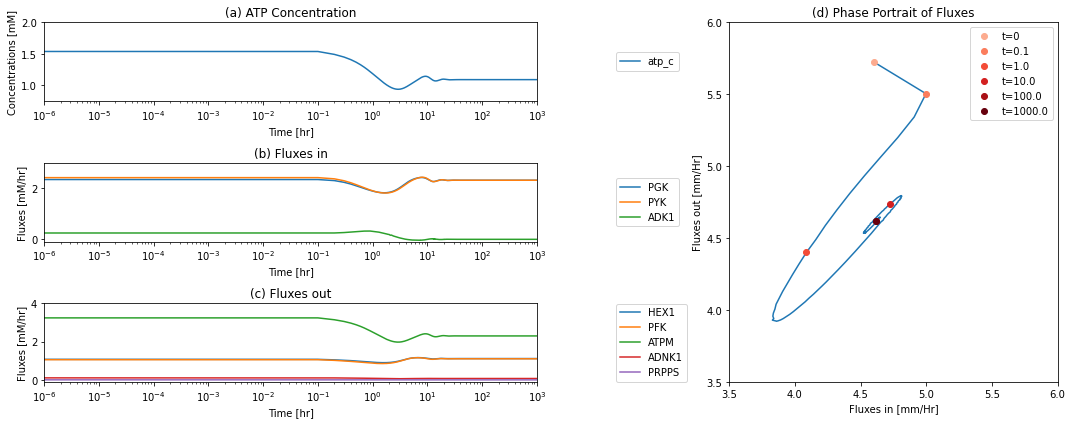

In [41]:
fig_12_14 = plt.figure(figsize=(15, 6))
gs = fig_12_14.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_12_14.add_subplot(gs[0, 0])
ax2 = fig_12_14.add_subplot(gs[1, 0])
ax3 = fig_12_14.add_subplot(gs[2, 0])
ax4 = fig_12_14.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="atp_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(.75, 2),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) ATP Concentration", L_FONT));

fluxes_in = ["PGK", "PYK", "ADK1"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(-0.1, 3),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["HEX1", "PFK", "ATPM", "ADNK1", "PRPPS"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(-0.1, 4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(3.5, 6.0), ylim=(3.5, 6.0),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");
fig_12_14.tight_layout()

**Figure 12.14:** The time profiles of the (a) ATP concentration, (b) the fluxes that make ATP, (c) the fluxes that use ATP and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales) for an increase in ATP utilization.

#### The AMP node
From the node map of AMP, we see that the biggest fluxes through the node are $v_{ADNK1}$ and $v_{NTD7}$.

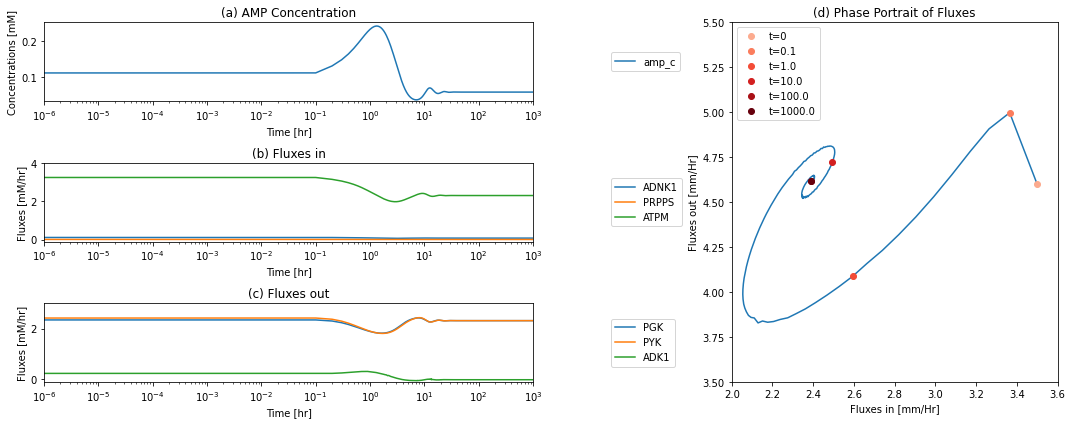

In [42]:
fig_12_15 = plt.figure(figsize=(15, 6))
gs = fig_12_15.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_12_15.add_subplot(gs[0, 0])
ax2 = fig_12_15.add_subplot(gs[1, 0])
ax3 = fig_12_15.add_subplot(gs[2, 0])
ax4 = fig_12_15.add_subplot(gs[:, 1])

plot_time_profile(conc_sol, observable="amp_c", ax=ax1, 
                legend="right outside", plot_function="semilogx",
                xlim=(1e-6, tf), ylim=(.035, 0.25),
                xlabel="Time [hr]", ylabel="Concentrations [mM]",
                title=("(a) AMP Concentration", L_FONT));

fluxes_in = ["ADNK1", "PRPPS", "ATPM"]
plot_time_profile(flux_sol, observable=fluxes_in, ax=ax2,
                legend="right outside", plot_function="semilogx",
                xlim=(1e-6, tf), ylim=(-0.1, 4),
                xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
                title=("(b) Fluxes in", L_FONT));

fluxes_out = ["PGK", "PYK","ADK1"]
plot_time_profile(flux_sol, observable=fluxes_out, ax=ax3, 
                legend="right outside", plot_function="semilogx",
                xlim=(1e-6, tf), ylim=(-0.1, 3),
                xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
                title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(2.0, 3.6), ylim=(3.5, 5.5),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");
fig_12_15.tight_layout()

**Figure 12.15:** The time profiles of the (a) AMP concentration, (b) the fluxes that make AMP, (c) the fluxes that use AMP and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales) for an increase in ATP utilization.

We highlight two aspects of this simulation: 

**1.** _Flux balancing of the AMP node:_ Previously, the influx (formation) of AMP into the system has been constant, but the output (degradation) was a linear function of AMP. In the integrated model simulated here, the formation of AMP is now explicitly represented by a biosynthetic pathway. We thus plot the phase portrait of the sum of all the formation and the sum of all degradation fluxes of AMP, Figure 12.16a. The 45 degree line in this diagram represents the steady state. The initial reaction to the perturbation is motion above the 45 degree line where there is net consumption of AMP. The trajectory turns around and heads towards the steady state line, overshoots it at first, but eventually settles down in the steady state. 

The phase portrait of the ATP load flux and the net AMP consumption rate was considered in the earlier chapters and is shown in Figure 12.16b. As before, the sudden increase in the ATP is followed by a net removal of AMP from the system and a dropping ATP load flux to reach the steady state again. 

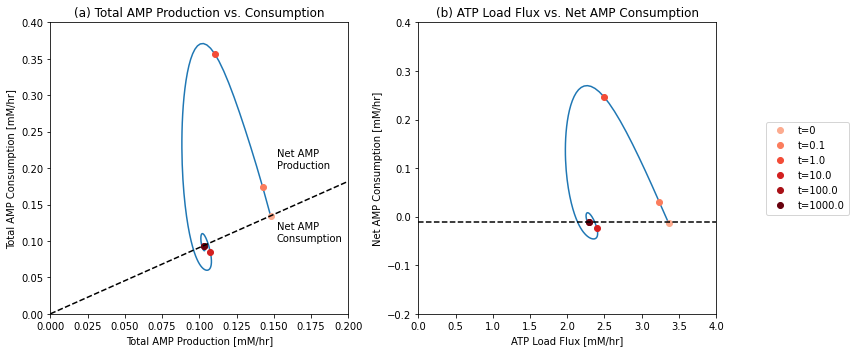

In [43]:
fig_12_16, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
(ax1, ax2) = axes.flatten()

equation_dict = {
    "AMP_Production": ["ADNK1 + ADPT + PRPPS", ["ADNK1", "ADPT", "PRPPS"]],
    "AMP_Consumption":["AMPDA + NTD7", ["AMPDA", "NTD7"]],
    "ATP_Load_Flux": ["ATPM", ["ATPM"]],
    "Net_AMP_Consumption": [
        "-(ADNK1 + ADPT + PRPPS) + (AMPDA + NTD7)", [
            "ADNK1", "ADPT", "PRPPS", "AMPDA", "NTD7"]]}

for sol_id, (equation, variables) in equation_dict.items():
    flux_sol.make_aggregate_solution(
        sol_id, equation=equation, variables=variables)
        
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="AMP_Production", y="AMP_Consumption", ax=ax1,
    xlim=(0, 0.2), ylim=(0, 0.4),  
    xlabel="Total AMP Production [mM/hr]", 
    ylabel="Total AMP Consumption [mM/hr]",
    title=("(a) Total AMP Production vs. Consumption", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors);

ax1.plot([0, .33], [0, .30], "k--")
ax1.annotate("Net AMP\nProduction", xy=(0.152, 0.2), textcoords="data")
ax1.annotate("Net AMP\nConsumption", xy=(0.152, 0.1), textcoords="data")

plot_phase_portrait(
    flux_sol, x="ATP_Load_Flux", y="Net_AMP_Consumption", ax=ax2,
    xlim=(0, 4), ylim=(-0.2, 0.4),
    xlabel="ATP Load Flux [mM/hr]", 
    ylabel="Net AMP Consumption [mM/hr]",
    title=("(b) ATP Load Flux vs. Net AMP Consumption", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside");

ax2.plot([-.01, 4], [-.01, -.01], "k--");
fig_12_16.tight_layout()

**Figure 12.16:** Dynamic response of the combined glycolytic, pentose pathway, and AMP metabolism network to a 50% increase in the rate of ATP use. (a) The phase portrait of total AMP consumption and production fluxes. The 45 degree line is the steady state, above which there is a net consumption (i.e., efflux) from the AMP node and below which there is a net production (i.e., import) of AMP. (b) The phase portrait of ATP load and net AMP consumption fluxes. See Figures 10.15a and 11.13a for comparison.

**2.** _Comparison with the coupled glycolytic pentose pathway network from the previous chapter:_ The phase portrait trajectory is qualitatively similar to simulated responses in previous chapters where the nucleotide metabolism is not explicitly described. To get a quantitative comparison of the effects of detailing AMP metabolism, we simulate the glycolytic and pentose pathway model of the previous chapter and compare it to the integrated model developed in this chapter (see Figure 12.17). The time response of ATP (Figure 12.17a) shows a more dampened response of the system with AMP metabolism versus the system without it. The same is true for the AMP response (Figure 12.17b) and the long term transient is less pronounced. The phase portrait of the sum of ATP consuming and producing fluxes (Figure 12.17c) shows how the fluxes come into the new steady state more quickly than when AMP metabolism is not detailed. 
    
Thus, the additional dynamic features of AMP concentration reduce the dampened oscillations. The AMP level is able to more quickly reach the new steady state in the integrated model.

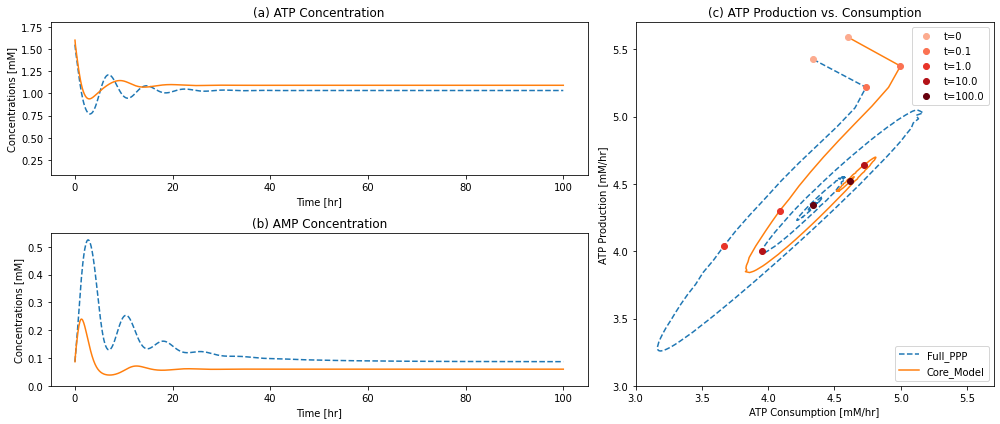

In [44]:
t0, tf = (0, 1e2)

fig_12_17 = plt.figure(figsize=(14, 6))
gs = fig_12_17.add_gridspec(nrows=2, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_12_17.add_subplot(gs[0, 0])
ax2 = fig_12_17.add_subplot(gs[1, 0])
ax3 = fig_12_17.add_subplot(gs[:, 1])


equation_dict = {
    "ATP_Consumption": ["ADK1 + PGK + PYK", ["ADK1", "PGK", "PYK"]],
    "ATP_Production": ["ATPM + HEX1 + PFK", ["ATPM", "HEX1", "PFK"]]}

time_points = [t0, 1e-1, 1e0, 1e1, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

colors = ["grey", "black"]
linestyles = ["--", "-"]
for i, model in enumerate([fullppp, core_network]):
    if i == 0:
        time_points_legend = "right outside"
    else:
        time_points_legend = None
    sim = Simulation(model)
    sim.find_steady_state(model, strategy="simulate",
                          update_values=True)
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf, tf*10 + 1),
        perturbations={"kf_ATPM": "kf_ATPM * 1.5"})
    for sol_id, (equation, variables) in equation_dict.items():
        flux_sol.make_aggregate_solution(
            sol_id, equation=equation, variables=variables)

    plot_time_profile(
        conc_sol, observable="atp_c", ax=ax1,
        ylim=(.08, 1.8), 
        xlabel="Time [hr]", ylabel="Concentrations [mM]",
        title=("(a) ATP Concentration", L_FONT),
        linestyle=linestyles[i]);
    
    plot_time_profile(
        conc_sol, observable="amp_c", ax=ax2, ylim=(0, 0.55),
        xlabel="Time [hr]", ylabel="Concentrations [mM]",
        title=("(b) AMP Concentration", L_FONT),
        linestyle=linestyles[i]);
    
    plot_phase_portrait(
        flux_sol, x="ATP_Consumption", y="ATP_Production", ax=ax3,
        legend=(model.id, "lower right"),
        xlim=(3, 5.7), ylim=(3, 5.7),
        xlabel="ATP Consumption [mM/hr]", ylabel="ATP Production [mM/hr]",
        title=("(c) ATP Production vs. Consumption", L_FONT),
        linestyle=linestyles[i],
        annotate_time_points=time_points,
        annotate_time_points_color=time_point_colors,
        annotate_time_points_legend="upper right");
fig_12_17.tight_layout()

**Figure 12.17:** Dynamic response of the combined glycolytic and pentose pathway network (dashed line) and the glycolytic, pentose pathway, and AMP metabolism network (solid line) to a 50% increase in the rate of ATP use. (a) ATP concentration. (b) AMP concentration. (c) the dynamic phase portrait of ATP consumption and production fluxes. 

#### Key Fluxes and all pairwise phase portraits

Figure 12.18 and Figure 12.19 are set up to allow the reader to examine all pairwise phase portraits  After browsing through many of them, you will find that they resemble each other, showing that the variables move in a highly coordinated manner.  We can study the relationship between many variables at once using multi-variate statistics.  

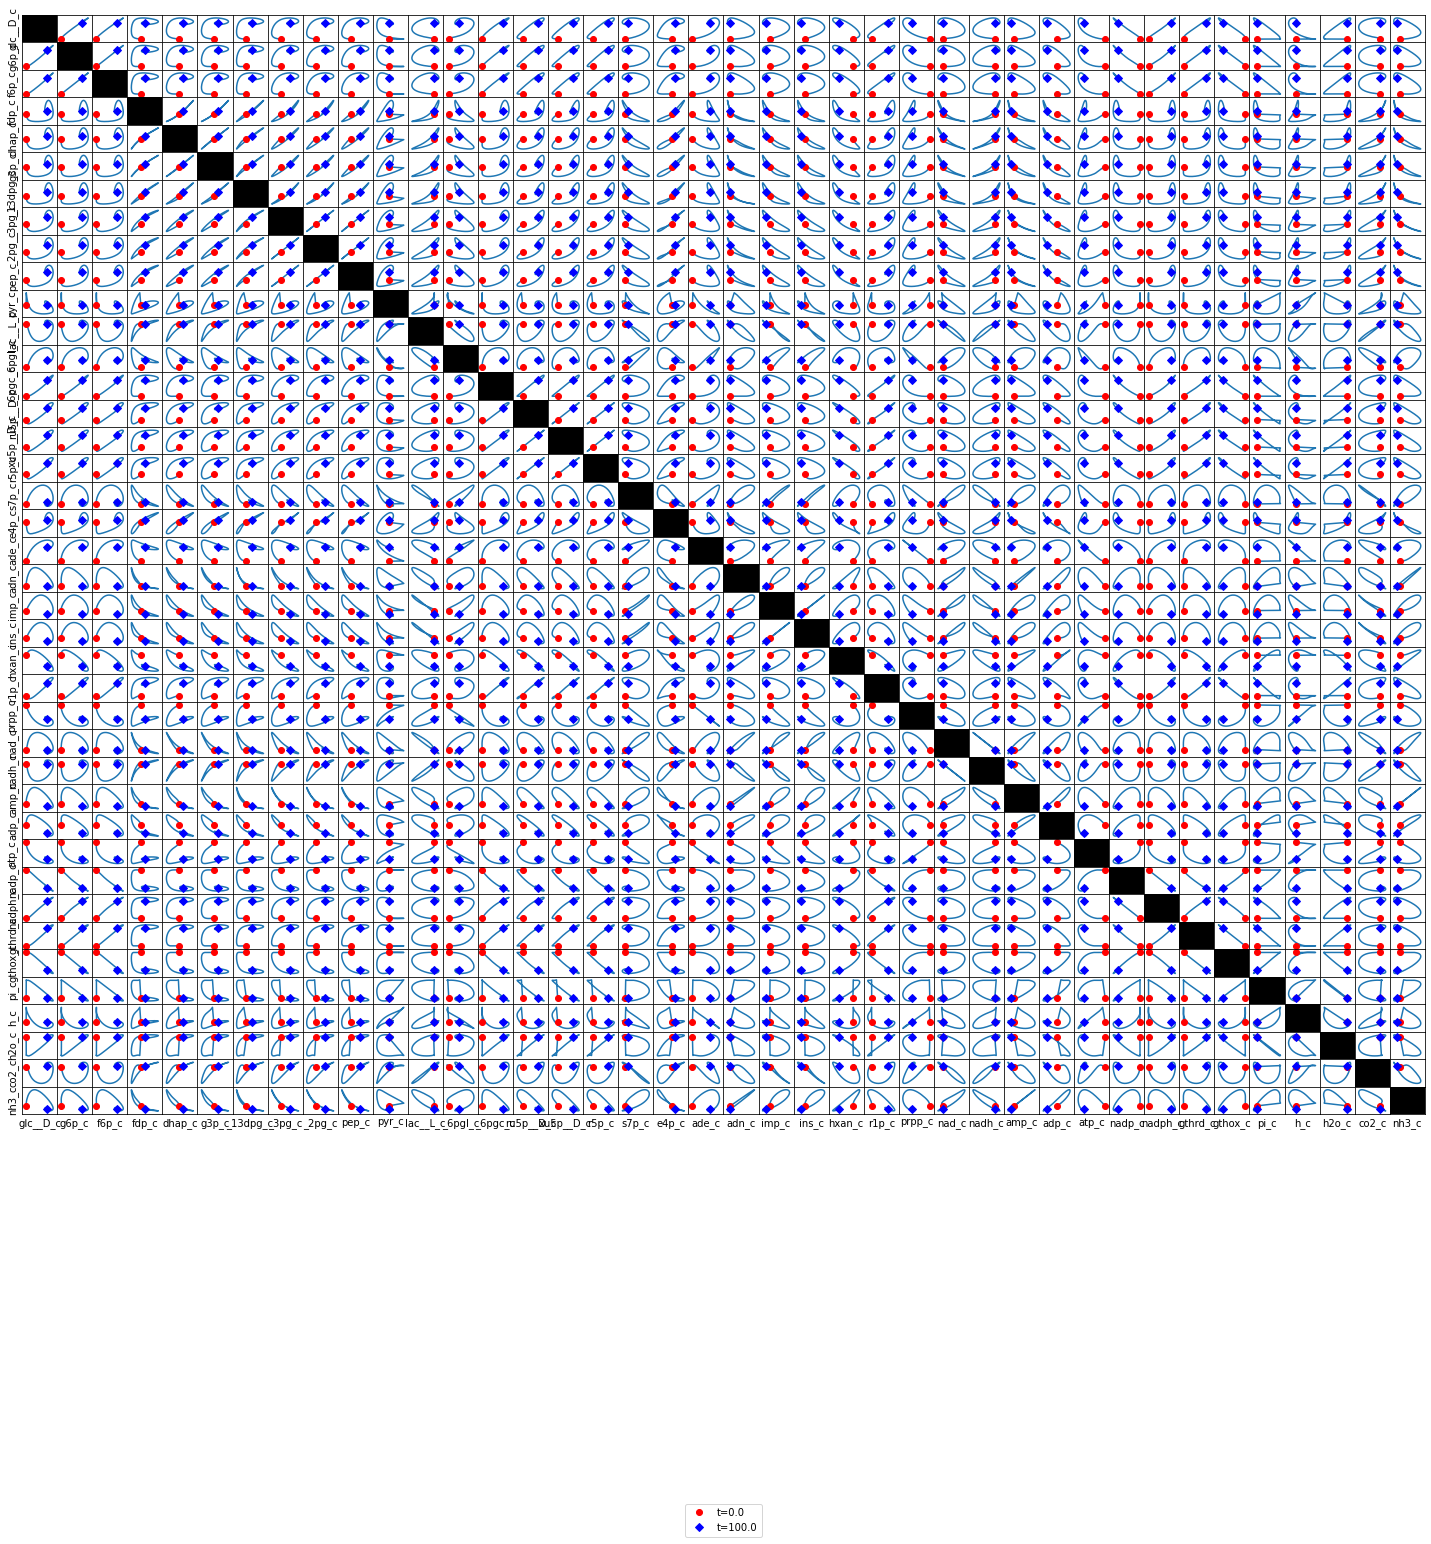

In [45]:
fig_12_18, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 22))
plot_tiled_phase_portraits(
    conc_sol, ax=ax, annotate_time_points_legend="lower outside");
fig_12_18.tight_layout()

**Figure 12.18:** Phase portraits of all the combined glycolytic, pentose phosphate pathway, and AMP salvage network species.

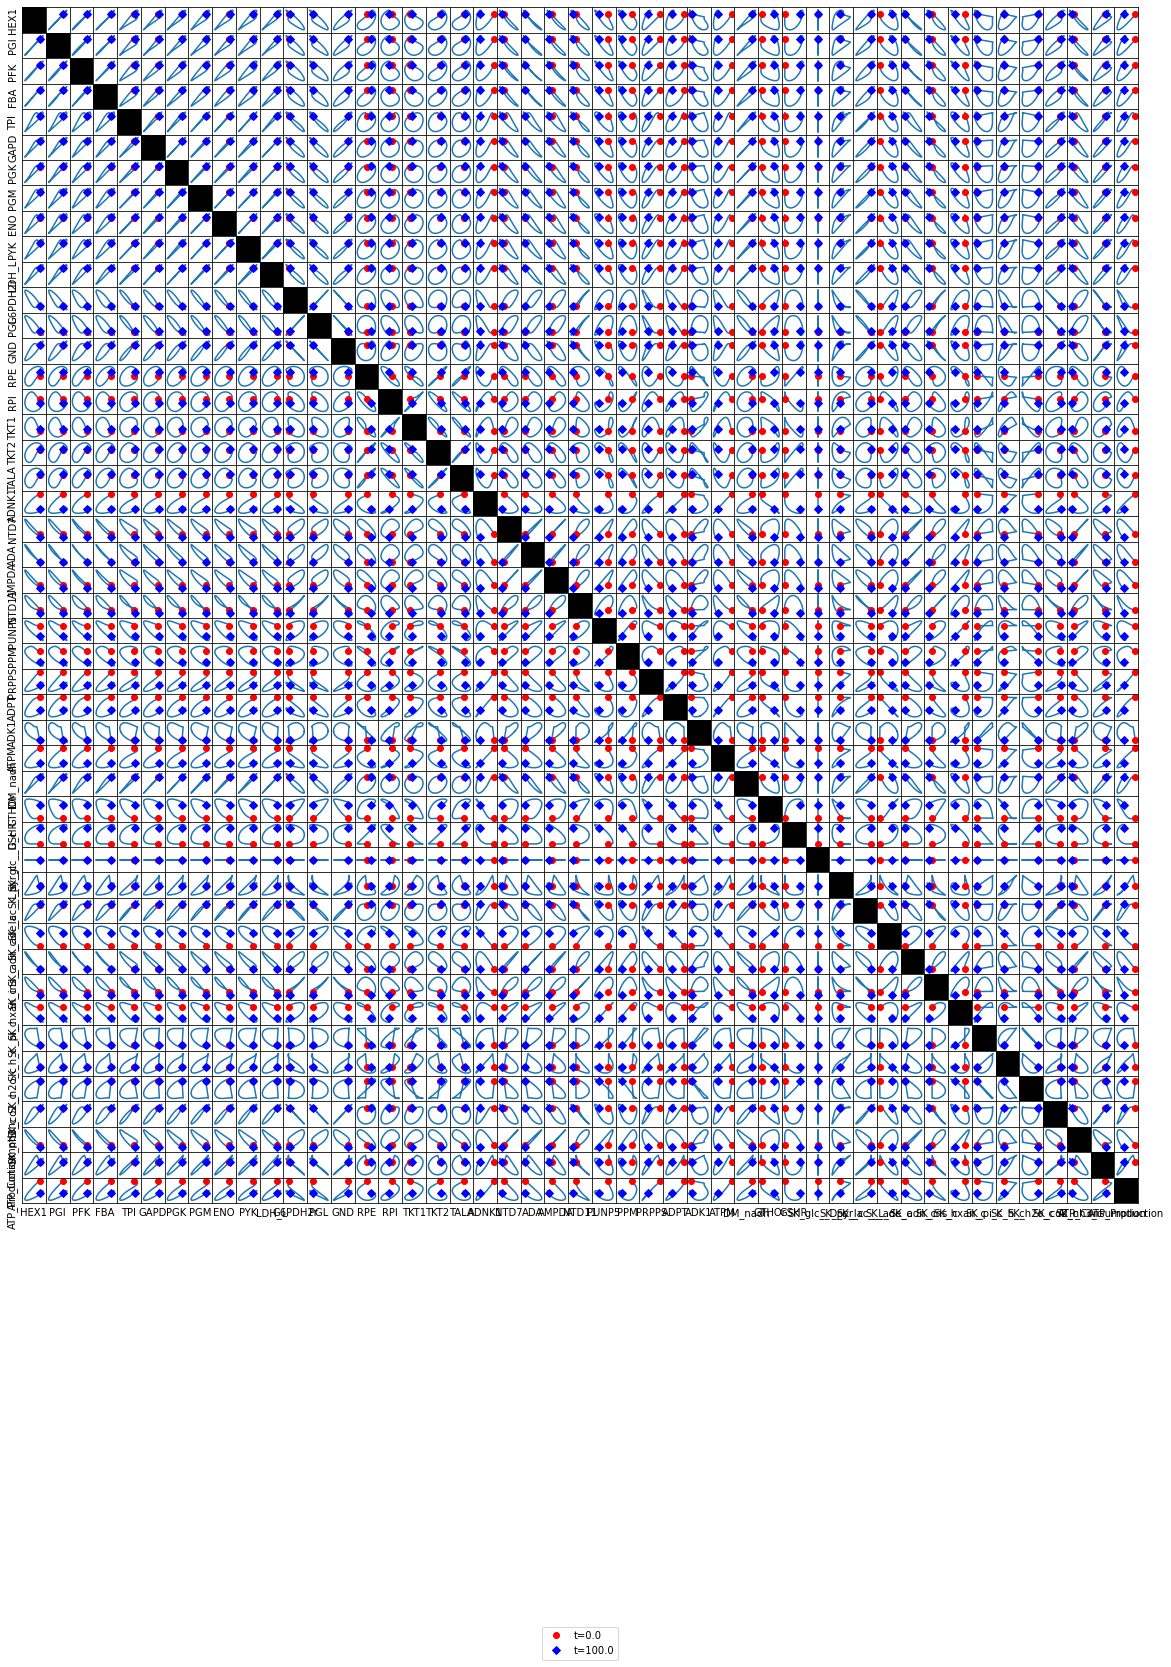

In [46]:
fig_12_19, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 22))
plot_tiled_phase_portraits(
    flux_sol, ax=ax, annotate_time_points_legend="lower outside");

**Figure 12.19:** Phase portraits of all the combined glycolytic, pentose phosphate pathway, and AMP salvage network fluxes.

## Whole Cell Models    

The network described herein encompasses the core metabolic functions in the human red blood cell. One can continue to build metabolic processes into this network model following the procedures outlined in this chapter. To build a more comprehensive model we would have to account for more details, such as osmotic pressure and electroneutrality (Joshi 1989). The inclusion of these effects come with complex mathematics, but account for very important physiological processes. The sodium potassium pump would also have to be accounted for as it is a key process in maintaining osmotic balance and cell shape. Another complication that arises pertains to the magnesium ion and the fact that it binds ATP to form MgATP (which is actually the substrate of many of the glycolytic enzymes) and to 23DPG to form Mg23DPG. 

The metabolites also bind to macromolecules. Some macromolecules have many ligands leading to a multiplicity of bound states. The bound states will alter the properties of the macromolecules. In the next part of the book we illustrate this phenomena for hemoglobin and for a regulated enzyme, PFK. 

![Figure-12-20](../images/Ch12/Figure-12-20.png)

**Figure 12.20:** Metabolic machinery and metabolic demand on the red blood cell. Redrawn from (Joshi 1989-1). 

These processes can be added in a stepwise fashion to increase the scope of the model and develop it towards a whole cell model. Once comprehensive coverage of the known processes in a cell is achieved, a good physiological representation is obtained. For the simple red blood cell, such a representation is achievable and one can match the 'metabolic machinery' with the 'metabolic demands' that are placed on a cell (see Figure 12.20). Coordination is achieved through regulation. Clearly, the metabolic network is satisfying multiple functions simultaneously, an important feature of systems biology. 

## Summary  

* Network reconstruction proceeds in a stepwise fashion by systematically integrating sub-networks. New issues may arise during each step of the integration process. 

* The addition of the AMP sub-network introduces a few integration issues. These include the reactions that have common metabolites in the two networks being integrated, new plasma exchange reactions, and the detailing of stoichiometry that may have been simplified. 

* The addition of the AMP synthesis and degradation sub-network introduces five new dimensions in the null space of S where three represent the degradation of AMP and two represent the biosynthesis of AMP. New network level pathways are introduced. 

* One can continue to integrate more and more biochemical processes known to occur in a cell using the procedures outlined in this chapter. For simple cells, this process can approach a comprehensive description of the cell and thus approach a whole-cell model. In addition to metabolic processes, a number of physico-chemical processes need to be added, and the functions of macromolecules can be incorporated, as described in the next part of this text. 

* A large model can be analyzed and conceptualized at the three levels (biochemistry, systems biology, and physiology) as detailed for glycolysis in Chapter 10. 

$\tiny{\text{© B. Ø. Palsson 2011;}\ \text{This publication is in copyright.}\\ \text{Subject to statutory exception and to the provisions of relevant collective licensing agreements,}\\ \text{no reproduction of any part may take place without the written permission of Cambridge University Press.}}$